# Установка необходимых библиотек

In [1]:
PROXY_API_KEY = "your_token_here"

In [2]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00


In [3]:
!pip install pandas

# Работа с GPT

In [ ]:
import pandas as pd
import json
from openai import OpenAI
from datetime import datetime
from tqdm import tqdm

In [ ]:
from openai import OpenAI

client = OpenAI(
    api_key=f"{PROXY_API_KEY}",
    base_url="https://api.proxyapi.ru/openai/v1",
)

chat_completion = client.chat.completions.create(
    model="gpt-3.5-turbo", messages=[{"role": "user", "content": "Привет мир!"}]
)


In [ ]:
chat_completion

ChatCompletion(id='chatcmpl-9OsH8GweAlAe5loBEIy74dxSjMkid', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Привет! Как я могу помочь вам сегодня?', role='assistant', function_call=None, tool_calls=None))], created=1715715534, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=20, prompt_tokens=13, total_tokens=33))

In [ ]:
chat_completion.choices[0].message.content

'Привет! Как я могу помочь вам сегодня?'

In [ ]:
def make_prompt(review_text):
    return f"""
Вы - менеджер по продукту, который должен изучить пользовательский опыт вашего приложения.

Вы должны проанализировать следующий обзор и выделить основную тему отзыва о приложении (максимум 3 темы, минимум - 0 тем).

Каждая тема в отзыве должна описывать конкретную функциональность или проблему приложения. Темы должны потенциально иметь решение. Абстрактные темы, к которым нельзя подобрать решение, не подходят.


Шаг 1: Извлеките первую основную тему о приложении.

Шаг 2: Извлеките вторую основную тему отзыва о приложении. Сравните эту тему с первой. Если они похожи, то используйте только первую тему.

Шаг 3: Извлеките третью основную тему отзыва о приложении. Сравните эту тему с первой и второй. Если они похожи, используйте только предыдущие темы.

Шаг 4: Проверьте, действительно ли извлеченные темы посвящены именно функциям или проблемам приложения.
Если нет, то верните "no topics".

Шаг 5: Если темы извлечены, то для каждой извлеченной темы определите настроение отзыва
   - positive/negative/neutral.

Настроение должно быть связано с восприятием пользователя в настоящем времени, слова типа "сейчас" могут описывать текущее настроение.

Выведи ТОЛЬКО СЫРОЙ JSON файл с тексто на английском языке, ничего больше, пожалуйста, это очень важно.

{{
"topics": {{"topic1": "sentiment1", "topic2": "sentiment2", "topic3": "sentiment3"}},
"explanation": "вexplain your decision here"
}}

Если топиков не обнаружено, не оставляй поле "topics" в JSON как пустое, вставь туда словарь {{"no topics": "no sentiment"}}. JSON should be in english.

Текст отзыва:
```
{review_text}
```
"""

In [ ]:
def analyze_reviews_with_gpt(df, column_name, model_name="gpt-3.5-turbo", max_tokens=1000):
    responses = []

    for index, row in tqdm(df.iterrows()):
        review = row[column_name]
        try:
            # Construct the prompt for the chat model
            prompt_messages = [
                {"role": "system", "content": "Вы - полезный ассистент, обученный анализировать отзывы о товарах."},
                {"role": "user", "content": make_prompt(review)}
            ]


            if model_name.startswith("gpt-4"):
                response = client.chat.completions.create(
                    model=model_name,
                    max_tokens=max_tokens,
                    messages=prompt_messages
                )
            else:
                response = client.chat.completions.create(
                    model=model_name,
                    messages=prompt_messages
                )

            # Extracting the text from the response
            responses.append(response.choices[0].message.content)
        except Exception as e:
            print(f"Failed to process review at index {index}: {str(e)}")
            responses.append("Failed to analyze")


    df['Analysis'] = responses
    return df


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/tech_diploma/scrap_reviews/data/cleaner_money_manager_reviews.csv")

In [ ]:
df.head()

,app_name,app_id,rating,review_text,date_of_review
1,cleaner_money_manager,ru.innim.my_finance,5,Literally changed my life. So easy and fun to ...,2022-01-23
2,cleaner_money_manager,ru.innim.my_finance,4,It seems that the categories are shown in the ...,2021-01-06
3,cleaner_money_manager,ru.innim.my_finance,4,"This app is versatile, customisable and easy t...",2024-04-01
4,cleaner_money_manager,ru.innim.my_finance,5,Amazing! I've tried various budget apps and no...,2024-04-06
5,cleaner_money_manager,ru.innim.my_finance,3,I'm on the fence about this budget app. It has...,2024-01-20


In [ ]:
df.isna().sum()

app_name          0
app_id            0
rating            0
review_text       0
date_of_review    0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df['date_of_review'] =  df['date_of_review'].apply(lambda x: datetime.strptime(x, "%B %d, %Y"))

In [ ]:
df.head()

,app_name,app_id,rating,review_text,date_of_review
1,cleaner_money_manager,ru.innim.my_finance,5,Literally changed my life. So easy and fun to ...,2022-01-23
2,cleaner_money_manager,ru.innim.my_finance,4,It seems that the categories are shown in the ...,2021-01-06
3,cleaner_money_manager,ru.innim.my_finance,4,"This app is versatile, customisable and easy t...",2024-04-01
4,cleaner_money_manager,ru.innim.my_finance,5,Amazing! I've tried various budget apps and no...,2024-04-06
5,cleaner_money_manager,ru.innim.my_finance,3,I'm on the fence about this budget app. It has...,2024-01-20


In [ ]:
df_small = df.copy().iloc[:5, :]
df_small.shape

(5, 5)

In [ ]:
analyze_reviews_with_gpt(df.iloc[2:6, :], "review_text")

<ipython-input-45-821f4ff23580>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


,app_name,app_id,rating,review_text,date_of_review,Analysis
3,cleaner_money_manager,ru.innim.my_finance,4,"This app is versatile, customisable and easy t...",2024-04-01,"{\n\t""topic_name"": [""Standing orders feature"",..."
4,cleaner_money_manager,ru.innim.my_finance,5,Amazing! I've tried various budget apps and no...,2024-04-06,"{\n""topic_name"": [""Visually appealing interfac..."
5,cleaner_money_manager,ru.innim.my_finance,3,I'm on the fence about this budget app. It has...,2024-01-20,"{\n""topic_name"": [""Syncing between devices"",""L..."
6,cleaner_money_manager,ru.innim.my_finance,3,This is more of an expe se tracker than budget...,2024-03-02,"{\n""topic_name"": [""Expense Tracking"", ""Budget ..."


In [ ]:
df.iloc[2:6, :]

,app_name,app_id,rating,review_text,date_of_review
3,cleaner_money_manager,ru.innim.my_finance,4,"This app is versatile, customisable and easy t...",2024-04-01
4,cleaner_money_manager,ru.innim.my_finance,5,Amazing! I've tried various budget apps and no...,2024-04-06
5,cleaner_money_manager,ru.innim.my_finance,3,I'm on the fence about this budget app. It has...,2024-01-20
6,cleaner_money_manager,ru.innim.my_finance,3,This is more of an expe se tracker than budget...,2024-03-02


In [ ]:
df_first_50 = analyze_reviews_with_gpt(df.iloc[:50, :], "review_text")

<ipython-input-45-821f4ff23580>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


In [ ]:
df_first_50

,app_name,app_id,rating,review_text,date_of_review,Analysis
1,cleaner_money_manager,ru.innim.my_finance,5,Literally changed my life. So easy and fun to ...,2022-01-23,"{\n""topic_name"": [""Expense tracking"", ""Budgeti..."
2,cleaner_money_manager,ru.innim.my_finance,4,It seems that the categories are shown in the ...,2021-01-06,"{\n""topic_name"": [""Category sorting feature"", ..."
3,cleaner_money_manager,ru.innim.my_finance,4,"This app is versatile, customisable and easy t...",2024-04-01,"\n{\n""topic_name"": [""Ability to create standin..."
4,cleaner_money_manager,ru.innim.my_finance,5,Amazing! I've tried various budget apps and no...,2024-04-06,"{\n""topic_name"": [""Upgrade to paid version"", ""..."
5,cleaner_money_manager,ru.innim.my_finance,3,I'm on the fence about this budget app. It has...,2024-01-20,"{\n""topic_name"": [""Syncing between devices"", ""..."
6,cleaner_money_manager,ru.innim.my_finance,3,This is more of an expe se tracker than budget...,2024-03-02,"{\n""topic_name"": [""Budgeting feature"", ""Income..."
7,cleaner_money_manager,ru.innim.my_finance,5,"Love the simplicity. I don't understand the ""M...",2024-02-05,"{\n""topic_name"": [""Simplicity"", ""Total balance..."
8,cleaner_money_manager,ru.innim.my_finance,5,"The App is very useful, user-friendly, simple ...",2024-02-10,"{\n""topic_name"": [""User-friendly interface"", ""..."
9,cleaner_money_manager,ru.innim.my_finance,2,I find this complicated to use. Be great if th...,2024-02-20,"{\n""topic_name"": [""User Interface Design""],\n""..."
10,cleaner_money_manager,ru.innim.my_finance,3,"Quite good app, although a bit slow and cumber...",2024-02-01,"{\n""topic_name"": [""feature 1"", ""feature 2"", ""f..."


In [ ]:
df_first_50.to_csv("/content/drive/MyDrive/tech_diploma/gpt_reviews/df_first_50.csv", index=False)

In [ ]:
df_second_50 = analyze_reviews_with_gpt(df.iloc[50:100, :], "review_text")

# Данные

## Coin Keeper

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/tech_diploma/scrap_reviews/ru_data/coin_keeper_1000_reviews_ru.csv")

In [ ]:
df.head()

,app_name,app_id,rating,review_text,date_of_review
0,coin_keeper,com.disrapp.coinkeeper.material,4,"Пользуюсь данным приложением с 2016 года, посл...",6 мая 2024 г.
1,coin_keeper,com.disrapp.coinkeeper.material,3,"Неудобная история трат, урезанная веб версия. ...",5 мая 2024 г.
2,coin_keeper,com.disrapp.coinkeeper.material,4,Сделайте пожалуйста встроенный калькулятор.,5 мая 2024 г.
3,coin_keeper,com.disrapp.coinkeeper.material,5,Мне норм понравилось,3 мая 2024 г.
4,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь этим приложением много лет, подписка...",3 мая 2024 г.


In [ ]:
months_translation = {
    'января': 'January',
    'февраля': 'February',
    'марта': 'March',
    'апреля': 'April',
    'мая': 'May',
    'июня': 'June',
    'июля': 'July',
    'августа': 'August',
    'сентября': 'September',
    'октября': 'October',
    'ноября': 'November',
    'декабря': 'December'
}


def translate_and_convert(date_str, translation_dict):
    # Translate month names from Russian to English
    for rus, eng in translation_dict.items():
        if rus in date_str:
            date_str = date_str.replace(rus, eng)
            break

    # Remove the ' г.' part
    date_str = date_str.replace(' г.', '')

    # Convert to datetime
    return pd.to_datetime(date_str, format='%d %B %Y')



In [ ]:
df['date'] = df['date_of_review'].apply(translate_and_convert, translation_dict=months_translation)

In [ ]:
df.head()

,app_name,app_id,rating,review_text,date_of_review,date
0,coin_keeper,com.disrapp.coinkeeper.material,4,"Пользуюсь данным приложением с 2016 года, посл...",6 мая 2024 г.,2024-05-06
1,coin_keeper,com.disrapp.coinkeeper.material,3,"Неудобная история трат, урезанная веб версия. ...",5 мая 2024 г.,2024-05-05
2,coin_keeper,com.disrapp.coinkeeper.material,4,Сделайте пожалуйста встроенный калькулятор.,5 мая 2024 г.,2024-05-05
3,coin_keeper,com.disrapp.coinkeeper.material,5,Мне норм понравилось,3 мая 2024 г.,2024-05-03
4,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь этим приложением много лет, подписка...",3 мая 2024 г.,2024-05-03


## Zen Money

In [ ]:
df_zen = pd.read_csv("/content/drive/MyDrive/tech_diploma/scrap_reviews/ru_data/zen_money_1000_reviews_ru.csv")

In [ ]:
df_zen.head()

,app_name,app_id,rating,review_text,date_of_review
0,zen_money,ru.zenmoney.androidsub,1,"пытаюсь войти, создать новый аккаунт или восст...",4 мая 2024 г.
1,zen_money,ru.zenmoney.androidsub,2,На данный момент(03.05.2024) приложение очень ...,3 мая 2024 г.
2,zen_money,ru.zenmoney.androidsub,5,Прекрасное приложение. Все чётко работает. Без...,1 мая 2024 г.
3,zen_money,ru.zenmoney.androidsub,5,"Постоянная поддержка, обновления, всё очень уд...",28 апреля 2024 г.
4,zen_money,ru.zenmoney.androidsub,1,"""Не распознано при получении"" Вручную нажимаю ...",28 апреля 2024 г.


In [ ]:
df_zen['date'] = df_zen['date_of_review'].apply(translate_and_convert, translation_dict=months_translation)

# Анализ отзывов с помощью GPT

In [ ]:
analyze_reviews_with_gpt(df.iloc[2:6, :], "review_text")

<ipython-input-14-39825160f684>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


,app_name,app_id,rating,review_text,date_of_review,date,Analysis
2,coin_keeper,com.disrapp.coinkeeper.material,4,Сделайте пожалуйста встроенный калькулятор.,5 мая 2024 г.,2024-05-05,"{\n""topics"": [""Встроенный калькулятор""],\n""sen..."
3,coin_keeper,com.disrapp.coinkeeper.material,5,Мне норм понравилось,3 мая 2024 г.,2024-05-03,"{\n""topics"": [],\n""sentiment"": ""нейтральный"",\..."
4,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь этим приложением много лет, подписка...",3 мая 2024 г.,2024-05-03,"{\n""topics"": [""Проблема с восстановлением дост..."
5,coin_keeper,com.disrapp.coinkeeper.material,3,"Can't reset password, not receiving anything t...",2 мая 2024 г.,2024-05-02,"{\n""topics"": [""проблема сброса пароля""],\n""sen..."


In [ ]:
analyze_reviews_with_gpt(df.iloc[2:6, :], "review_text")

<ipython-input-14-39825160f684>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


,app_name,app_id,rating,review_text,date_of_review,date,Analysis
2,coin_keeper,com.disrapp.coinkeeper.material,4,Сделайте пожалуйста встроенный калькулятор.,5 мая 2024 г.,2024-05-05,"{\n""topics"": [""Встроенный калькулятор""],\n""sen..."
3,coin_keeper,com.disrapp.coinkeeper.material,5,Мне норм понравилось,3 мая 2024 г.,2024-05-03,"{\n""topics"": [""нет тем""],\n""sentiment"": ""нейтр..."
4,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь этим приложением много лет, подписка...",3 мая 2024 г.,2024-05-03,"{\n""topics"": [""Проблемы с восстановлением учет..."
5,coin_keeper,com.disrapp.coinkeeper.material,3,"Can't reset password, not receiving anything t...",2 мая 2024 г.,2024-05-02,"{\n""topics"": [""Проблема сброса пароля""],\n""sen..."


Проверяем для первой 100 отзывов

In [ ]:
df_first_100_coin_keeper = analyze_reviews_with_gpt(df.iloc[:100, :], "review_text")

100it [04:20,  2.61s/it]
<ipython-input-21-4d419dc432e9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


In [ ]:
df_first_100_coin_keeper

,app_name,app_id,rating,review_text,date_of_review,date,Analysis
0,coin_keeper,com.disrapp.coinkeeper.material,4,"Пользуюсь данным приложением с 2016 года, посл...",6 мая 2024 г.,2024-05-06,"{\n""topics"": [""проблема с синхронизацией""],\n""..."
1,coin_keeper,com.disrapp.coinkeeper.material,3,"Неудобная история трат, урезанная веб версия. ...",5 мая 2024 г.,2024-05-05,"{\n""topics"": [""Отсутствие возможности экспорта..."
2,coin_keeper,com.disrapp.coinkeeper.material,4,Сделайте пожалуйста встроенный калькулятор.,5 мая 2024 г.,2024-05-05,"{\n""topics"": [""Функционал: встроенный калькуля..."
3,coin_keeper,com.disrapp.coinkeeper.material,5,Мне норм понравилось,3 мая 2024 г.,2024-05-03,"{\n""topics"": [""нет тем""],\n""sentiment"": ""нейтр..."
4,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь этим приложением много лет, подписка...",3 мая 2024 г.,2024-05-03,"{\n""topics"": [""проблема с входом в приложение""..."
...,...,...,...,...,...,...,...
95,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь 2 года, честно говоря не вижу каких-...",14 февраля 2024 г.,2024-02-14,"{\n""topics"": [""Отсутствие инноваций и изменени..."
96,coin_keeper,com.disrapp.coinkeeper.material,5,Появились баги в отражении изображении и текст...,13 февраля 2024 г.,2024-02-13,"{\n""topics"": [""Проблемы с отражением изображен..."
97,coin_keeper,com.disrapp.coinkeeper.material,5,"Всё, супер. Спасибо разработчикам.",11 февраля 2024 г.,2024-02-11,"{\n""topics"": [""нет топиков""],\n""sentiment"": ""п..."
98,coin_keeper,com.disrapp.coinkeeper.material,5,Люкс,10 февраля 2024 г.,2024-02-10,"{\n""topics"": [""Нет тем""],\n""sentiment"": ""Нет т..."


In [ ]:
df_first_50_coin_keeper_gpt4 = analyze_reviews_with_gpt(df.iloc[:50, :], "review_text", model_name="gpt-4-turbo")

1it [00:14, 14.72s/it]


KeyboardInterrupt: 

In [ ]:
df.head(20)

,app_name,app_id,rating,review_text,date_of_review,date
0,coin_keeper,com.disrapp.coinkeeper.material,4,"Пользуюсь данным приложением с 2016 года, посл...",6 мая 2024 г.,2024-05-06
1,coin_keeper,com.disrapp.coinkeeper.material,3,"Неудобная история трат, урезанная веб версия. ...",5 мая 2024 г.,2024-05-05
2,coin_keeper,com.disrapp.coinkeeper.material,4,Сделайте пожалуйста встроенный калькулятор.,5 мая 2024 г.,2024-05-05
3,coin_keeper,com.disrapp.coinkeeper.material,5,Мне норм понравилось,3 мая 2024 г.,2024-05-03
4,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь этим приложением много лет, подписка...",3 мая 2024 г.,2024-05-03
5,coin_keeper,com.disrapp.coinkeeper.material,3,"Can't reset password, not receiving anything t...",2 мая 2024 г.,2024-05-02
6,coin_keeper,com.disrapp.coinkeeper.material,1,Все сбилось в программе. При использовании с д...,30 апреля 2024 г.,2024-04-30
7,coin_keeper,com.disrapp.coinkeeper.material,1,"Не возможно войти в премиум подписку,выдает ош...",30 апреля 2024 г.,2024-04-30
8,coin_keeper,com.disrapp.coinkeeper.material,4,"Сделайте, пожалуйста, чтобы в Общие - Фильтры ...",30 апреля 2024 г.,2024-04-30
9,coin_keeper,com.disrapp.coinkeeper.material,4,"Ребята, почему сегодня перестали распознавать ...",30 апреля 2024 г.,2024-04-30


In [ ]:
df.iloc[[4, 8, 19], :]

,app_name,app_id,rating,review_text,date_of_review,date
4,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь этим приложением много лет, подписка...",3 мая 2024 г.,2024-05-03
8,coin_keeper,com.disrapp.coinkeeper.material,4,"Сделайте, пожалуйста, чтобы в Общие - Фильтры ...",30 апреля 2024 г.,2024-04-30
19,coin_keeper,com.disrapp.coinkeeper.material,1,Не верно считает остаток.,18 апреля 2024 г.,2024-04-18


In [ ]:
analyze_reviews_with_gpt(df.iloc[[4, 8, 19], :], "review_text", model_name="gpt-4-turbo")

3it [00:25,  8.59s/it]
<ipython-input-25-4d419dc432e9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


,app_name,app_id,rating,review_text,date_of_review,date,Analysis
4,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь этим приложением много лет, подписка...",3 мая 2024 г.,2024-05-03,"```json\n{\n""topics"": [""account access issue"",..."
8,coin_keeper,com.disrapp.coinkeeper.material,4,"Сделайте, пожалуйста, чтобы в Общие - Фильтры ...",30 апреля 2024 г.,2024-04-30,"```json\n{\n""topics"": [""manual date entry in f..."
19,coin_keeper,com.disrapp.coinkeeper.material,1,Не верно считает остаток.,18 апреля 2024 г.,2024-04-18,"{\n""topics"": [""no topics""],\n""sentiment"": ""neg..."


In [ ]:
chat_completion_gpt4 = client.chat.completions.create(
    model="gpt-4", max_tokens=1000, messages=[{"role": "user", "content": make_prompt("Хорошая программа. Помогает вести учёт. Удобно для семьи, так как каждый может вносить свои расходы в одном аккаунт. Почему-то перестала работать веб версия. Подскажите причину. Год спустя веб версия вообще пропала. Печально.")
    }]
)

In [ ]:
print(chat_completion_gpt4.choices[0].message.content)

{
"topics": ["accounting feature", "family usage", "web version"],
"sentiment": "mixed",
"explanation": "The review has a mixed sentiment. The user finds the accounting feature and the possibility to use the app by multiple family members positive. However, the review turns negative when the user mentions that the web version stopped working and eventually disappeared."
}


In [ ]:
df_first_50_coin_keeper_gpt4 = analyze_reviews_with_gpt(df.iloc[:50, :], "review_text", model_name="gpt-4-turbo")

In [ ]:
analyze_reviews_with_gpt(df.iloc[100:104, :], "review_text")

4it [00:07,  1.94s/it]
<ipython-input-25-4d419dc432e9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


,app_name,app_id,rating,review_text,date_of_review,date,Analysis
100,coin_keeper,com.disrapp.coinkeeper.material,1,"Вообще не понимаю, что в этом приложении есть ...",9 февраля 2024 г.,2024-02-09,"{\n""topics"": [""No topics""],\n""sentiment"": ""neg..."
101,coin_keeper,com.disrapp.coinkeeper.material,5,Хотелось бы узнать как можно купить приложение...,9 февраля 2024 г.,2024-02-09,"{\n""topics"": [""purchasing process""],\n""sentime..."
102,coin_keeper,com.disrapp.coinkeeper.material,5,Отличное приложение. Пользуюсь уже 4 года почт...,8 февраля 2024 г.,2024-02-08,"{\n""topics"": [""User Experience""],\n""sentiment""..."
103,coin_keeper,com.disrapp.coinkeeper.material,3,"Само по себе приложение классное, даже купил л...",8 февраля 2024 г.,2024-02-08,"{\n""topics"": [""Editing Expenses Functionality""..."


In [ ]:
analyze_reviews_with_gpt(df.iloc[[4, 8, 19], :], "review_text")

3it [00:05,  1.84s/it]
<ipython-input-39-67162dfeba87>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


,app_name,app_id,rating,review_text,date_of_review,date,Analysis
4,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь этим приложением много лет, подписка...",3 мая 2024 г.,2024-05-03,"\n{\n""topics"": {""login issue"": ""negative"", ""cu..."
8,coin_keeper,com.disrapp.coinkeeper.material,4,"Сделайте, пожалуйста, чтобы в Общие - Фильтры ...",30 апреля 2024 г.,2024-04-30,"\n{\n""topics"": {""Manual Date Entry in Filters""..."
19,coin_keeper,com.disrapp.coinkeeper.material,1,Не верно считает остаток.,18 апреля 2024 г.,2024-04-18,"{\n""topics"": {\n""calculation accuracy"": ""negat..."


Следующие 200

In [ ]:
df_100_200_coin_keeper = analyze_reviews_with_gpt(df.iloc[100:200, :], "review_text")

100it [02:37,  1.57s/it]
<ipython-input-39-67162dfeba87>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


In [ ]:
df_100_200_coin_keeper

,app_name,app_id,rating,review_text,date_of_review,date,Analysis
100,coin_keeper,com.disrapp.coinkeeper.material,1,"Вообще не понимаю, что в этом приложении есть ...",9 февраля 2024 г.,2024-02-09,"{\n""topics"": {""features and functionalities"": ..."
101,coin_keeper,com.disrapp.coinkeeper.material,5,Хотелось бы узнать как можно купить приложение...,9 февраля 2024 г.,2024-02-09,"{\n""topics"": {""Purchase Process"": ""negative""},..."
102,coin_keeper,com.disrapp.coinkeeper.material,5,Отличное приложение. Пользуюсь уже 4 года почт...,8 февраля 2024 г.,2024-02-08,"{\n""topics"": {""Ease of Use"": ""positive""},\n""ex..."
103,coin_keeper,com.disrapp.coinkeeper.material,3,"Само по себе приложение классное, даже купил л...",8 февраля 2024 г.,2024-02-08,"{\n""topics"": {\n""Editing Expenses Functionalit..."
104,coin_keeper,com.disrapp.coinkeeper.material,1,"Скачал приложение, решил купить премиум на год...",7 февраля 2024 г.,2024-02-07,"{\n""topics"": {""registration issue"": ""negative""..."
...,...,...,...,...,...,...,...
195,coin_keeper,com.disrapp.coinkeeper.material,3,"Добавьте пожалуйста тёмную тему, и расширьте в...",29 ноября 2023 г.,2023-11-29,"\n{\n""topics"": {""Dark mode option"": ""negative""..."
196,coin_keeper,com.disrapp.coinkeeper.material,1,Спустя секунду после открытия приложения полез...,27 ноября 2023 г.,2023-11-27,"{\n""topics"": {""subscription pop-up"": ""negative..."
197,coin_keeper,com.disrapp.coinkeeper.material,2,не могу сбросить пароль. пишу в поддержку на с...,27 ноября 2023 г.,2023-11-27,"{\n""topics"": {\n""password reset issue"": ""negat..."
198,coin_keeper,com.disrapp.coinkeeper.material,1,Даже не начала пробовать. Нет выбора валют. Оч...,25 ноября 2023 г.,2023-11-25,"\n{\n""topics"": {""Limited currency options"": ""n..."


**200-500**

In [ ]:
df_200_500_coin_keeper = analyze_reviews_with_gpt(df.iloc[200:500, :], "review_text")

300it [09:02,  1.81s/it]
<ipython-input-9-bf3301928eb8>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


**500-800**

In [ ]:
df_500_800_coin_keeper = analyze_reviews_with_gpt(df.iloc[500:800, :], "review_text")

300it [09:04,  1.82s/it]
<ipython-input-9-bf3301928eb8>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


**800-1000**

In [ ]:
df_800_1000_coin_keeper = analyze_reviews_with_gpt(df.iloc[800:, :], "review_text")

200it [05:56,  1.78s/it]
<ipython-input-9-bf3301928eb8>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


**0-100**

In [ ]:
df_0_300_zen = analyze_reviews_with_gpt(df_zen.iloc[:300, :], "review_text")

300it [09:12,  1.84s/it]
<ipython-input-8-bf3301928eb8>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


In [ ]:
df_300_600_zen = analyze_reviews_with_gpt(df_zen.iloc[300:600, :], "review_text")

300it [09:18,  1.86s/it]
<ipython-input-8-bf3301928eb8>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


In [ ]:
df_600_1000_zen = analyze_reviews_with_gpt(df_zen.iloc[600:, :], "review_text")

400it [12:06,  1.82s/it]
<ipython-input-8-bf3301928eb8>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = responses


## Zen Money

# Итоговая обработка датасета с отзывами

In [ ]:
import pandas as pd
import json


def clean_and_parse_json(json_string):
    # Strip Markdown code block delimiters
    json_string = json_string.strip('`')  # Strip backticks around the JSON
    json_string = json_string.replace('json\n', '')  # Remove the 'json' keyword and newline after it
    json_string = json_string.strip()  # Clean any residual whitespace

    # Convert string to dictionary
    try:
        return json.loads(json_string)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON {json_string} : {e}")
        return None  # Return None if there's an error in parsing


def expand_json_row(row, col):
    # Parse the JSON data
    json_data = clean_and_parse_json(row[col])
    if json_data is None:
        return pd.DataFrame()# Return an empty DataFrame for this row

    # Check for 'explanation' key existence
    if 'explanation' not in json_data:
        return pd.DataFrame()  # Skip rows without an 'explanation'

    explanation = json_data['explanation']

    # Handle empty topics dictionary
    topics_dict = json_data.get('topics', {})
    if not topics_dict:  # if topics is empty
        topics_dict = {"no topics": "no sentiment"}

    # Initialize lists to store data for DataFrame creation
    data = []

    # Iterate over the topics dictionary
    for topic, sentiment in topics_dict.items():
        # Create a new record for each topic that includes existing row data
        new_record = row.to_dict()
        new_record.update({
            'topic_name': topic,
            'sentiment': sentiment,
            'explanation': explanation
        })
        data.append(new_record)

    # Create a DataFrame for the extracted data
    return pd.DataFrame(data)

# Function to expand the entire DataFrame
def expand_dataframe(df, col):
    expanded_dfs = []
    for index, row in df.iterrows():
        print(f"...parsing {index}...")
        expanded_df = expand_json_row(row, col)
        if not expanded_df.empty:
            expanded_dfs.append(expanded_df)
    return pd.concat(expanded_dfs, ignore_index=True) if expanded_dfs else pd.DataFrame()


In [ ]:
expand_dataframe(df_100_200_coin_keeper.iloc[:2, :], 'Analysis')

,topic_name,sentiment,explanation
0,features and functionalities,negative,The main theme of the review is criticism towa...
1,Purchase Process,negative,The main theme of the review is the difficulty...


In [ ]:
json.loads(df_100_200_coin_keeper["Analysis"][100])

{'topics': {'features and functionalities': 'negative'},
 'explanation': 'The main theme of the review is criticism towards the lack of positive features or functionalities in the app.'}

In [ ]:
expand_json_row(df_100_200_coin_keeper.iloc[12, :], "Analysis")

""


In [ ]:
df_100_200_coin_keeper.iloc[12, :]

app_name                                            coin_keeper
app_id                          com.disrapp.coinkeeper.material
rating                                                        5
review_text                                                Мощь
date_of_review                                1 февраля 2024 г.
date                                        2024-02-01 00:00:00
Analysis          {\n"topics": {"no topics": "no sentiment"}\n}
Name: 112, dtype: object

In [ ]:
expand_dataframe(df_100_200_coin_keeper, 'Analysis').drop(columns=["Analysis"])

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation
0,coin_keeper,com.disrapp.coinkeeper.material,1,"Вообще не понимаю, что в этом приложении есть ...",9 февраля 2024 г.,2024-02-09,features and functionalities,negative,The main theme of the review is criticism towa...
1,coin_keeper,com.disrapp.coinkeeper.material,5,Хотелось бы узнать как можно купить приложение...,9 февраля 2024 г.,2024-02-09,Purchase Process,negative,The main theme of the review is the difficulty...
2,coin_keeper,com.disrapp.coinkeeper.material,5,Отличное приложение. Пользуюсь уже 4 года почт...,8 февраля 2024 г.,2024-02-08,Ease of Use,positive,The main theme of the review is the ease of us...
3,coin_keeper,com.disrapp.coinkeeper.material,3,"Само по себе приложение классное, даже купил л...",8 февраля 2024 г.,2024-02-08,Editing Expenses Functionality,negative,The main themes extracted from the review are ...
4,coin_keeper,com.disrapp.coinkeeper.material,3,"Само по себе приложение классное, даже купил л...",8 февраля 2024 г.,2024-02-08,Feedback Form Functionality,negative,The main themes extracted from the review are ...
...,...,...,...,...,...,...,...,...,...
135,coin_keeper,com.disrapp.coinkeeper.material,2,не могу сбросить пароль. пишу в поддержку на с...,27 ноября 2023 г.,2023-11-27,password reset issue,negative,The main themes extracted from the review are ...
136,coin_keeper,com.disrapp.coinkeeper.material,2,не могу сбросить пароль. пишу в поддержку на с...,27 ноября 2023 г.,2023-11-27,support responsiveness,negative,The main themes extracted from the review are ...
137,coin_keeper,com.disrapp.coinkeeper.material,2,не могу сбросить пароль. пишу в поддержку на с...,27 ноября 2023 г.,2023-11-27,subscription notification problem,negative,The main themes extracted from the review are ...
138,coin_keeper,com.disrapp.coinkeeper.material,1,Даже не начала пробовать. Нет выбора валют. Оч...,25 ноября 2023 г.,2023-11-25,Limited currency options,negative,The main theme extracted from the review is th...


In [ ]:
df_2_5 = expand_dataframe(df_200_500_coin_keeper, 'Analysis').drop(columns=['Analysis'])
df_5_8 = expand_dataframe(df_500_800_coin_keeper, 'Analysis').drop(columns=['Analysis'])

pd.concat([df_2_5, df_5_8])

...parsing 200...
...parsing 201...
...parsing 202...
...parsing 203...
...parsing 204...
...parsing 205...
...parsing 206...
...parsing 207...
...parsing 208...
...parsing 209...
...parsing 210...
...parsing 211...
...parsing 212...
...parsing 213...
...parsing 214...
...parsing 215...
...parsing 216...
...parsing 217...
...parsing 218...
...parsing 219...
...parsing 220...
...parsing 221...
...parsing 222...
...parsing 223...
...parsing 224...
...parsing 225...
...parsing 226...
...parsing 227...
...parsing 228...
...parsing 229...
...parsing 230...
...parsing 231...
...parsing 232...
...parsing 233...
...parsing 234...
...parsing 235...
...parsing 236...
...parsing 237...
...parsing 238...
...parsing 239...
...parsing 240...
...parsing 241...
...parsing 242...
...parsing 243...
...parsing 244...
...parsing 245...
...parsing 246...
...parsing 247...
...parsing 248...
...parsing 249...
...parsing 250...
...parsing 251...
...parsing 252...
...parsing 253...
...parsing 254...
...parsing

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation
0,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь больше двух лет, работает стабильно,...",24 ноября 2023 г.,2023-11-24,Stability and Synchronization,positive,The main topics extracted from the review are ...
1,coin_keeper,com.disrapp.coinkeeper.material,5,"Пользуюсь больше двух лет, работает стабильно,...",24 ноября 2023 г.,2023-11-24,Paid Lifetime Version Features,positive,The main topics extracted from the review are ...
2,coin_keeper,com.disrapp.coinkeeper.material,1,Внимание - мошеннические действия ! Снимают де...,24 ноября 2023 г.,2023-11-24,fraudulent actions,negative,The main themes extracted from the review are ...
3,coin_keeper,com.disrapp.coinkeeper.material,1,Внимание - мошеннические действия ! Снимают де...,24 ноября 2023 г.,2023-11-24,lack of response to emails,negative,The main themes extracted from the review are ...
4,coin_keeper,com.disrapp.coinkeeper.material,1,хорошее приложение (старая 2 версия) сознатель...,23 ноября 2023 г.,2023-11-23,Loss of features,negative,The main themes extracted from the review are ...
...,...,...,...,...,...,...,...,...,...
414,coin_keeper,com.disrapp.coinkeeper.material,2,"Функции ограничены, а оплатить полную версию н...",8 января 2023 г.,2023-01-08,payment issue,negative,The main themes extracted from the review are ...
415,coin_keeper,com.disrapp.coinkeeper.material,2,2 раза списали оплату за подписку,7 января 2023 г.,2023-01-07,Payment Issue,negative,The main theme of the review is related to a p...
416,coin_keeper,com.disrapp.coinkeeper.material,1,Невозможно купить премиум. Приложение в мусорку:),5 января 2023 г.,2023-01-05,premium purchase issue,negative,The main theme of the review is the inability ...
417,coin_keeper,com.disrapp.coinkeeper.material,1,Покупала по акции подписку навсегда. Было года...,5 января 2023 г.,2023-01-05,subscription issue,negative,The review highlights issues related to subscr...


In [ ]:
"""{{
"topics": {{"Advertising Premium Content", "Help Page Loading Issue"}},
"explanation": "The review addresses the frustration of encountering premium content advertisements despite having paid for a premium subscription, questioning the purpose of such ads. Additionally, the user mentions the inability to load the 'Help' page, indicating a technical issue with accessing essential support information."
}}"""

clean_and_parse_json(f"""{{
"topics": {{"Advertising Premium Content", "Help Page Loading Issue"}},
"explanation": "The review addresses the frustration of encountering premium content advertisements despite having paid for a premium subscription, questioning the purpose of such ads. Additionally, the user mentions the inability to load the 'Help' page, indicating a technical issue with accessing essential support information."
}}""")

Error decoding JSON {
"topics": {"Advertising Premium Content", "Help Page Loading Issue"},
"explanation": "The review addresses the frustration of encountering premium content advertisements despite having paid for a premium subscription, questioning the purpose of such ads. Additionally, the user mentions the inability to load the 'Help' page, indicating a technical issue with accessing essential support information."
} : Expecting ':' delimiter: line 2 column 41 (char 42)


In [ ]:
df_200_500_coin_keeper.iloc[219]['Analysis'] = f"""{{
"topics": {{"Advertising Premium Content": "Help Page Loading Issue"}},
"explanation": "The review addresses the frustration of encountering premium content advertisements despite having paid for a premium subscription, questioning the purpose of such ads. Additionally, the user mentions the inability to load the 'Help' page, indicating a technical issue with accessing essential support information."
}}"""

<ipython-input-29-5ac62b26c0b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_200_500_coin_keeper.iloc[219]['Analysis'] = f"""{{


In [ ]:
df_200_500_coin_keeper.iloc[219]['Analysis']

'{\n"topics": {"Advertising Premium Content", "Help Page Loading Issue"},\n"explanation": "The review addresses the frustration of encountering premium content advertisements despite having paid for a premium subscription, questioning the purpose of such ads. Additionally, the user mentions the inability to load the \'Help\' page, indicating a technical issue with accessing essential support information."\n}'

In [ ]:
df_200_500_coin_keeper.at[219, 'Analysis'] = f"""{{
"topics": {{"Advertising Premium Content": "Help Page Loading Issue"}},
"explanation": "The review addresses the frustration of encountering premium content advertisements despite having paid for a premium subscription, questioning the purpose of such ads. Additionally, the user mentions the inability to load the 'Help' page, indicating a technical issue with accessing essential support information."
}}"""

In [ ]:
df_200_500_coin_keeper.loc[:, "Analysis"][419] = f"""{{
"topics": {{"Advertising Premium Content": "Help Page Loading Issue"}},
"explanation": "The review addresses the frustration of encountering premium content advertisements despite having paid for a premium subscription, questioning the purpose of such ads. Additionally, the user mentions the inability to load the 'Help' page, indicating a technical issue with accessing essential support information."
}}"""

<ipython-input-40-6284e7787bc9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_200_500_coin_keeper.loc[:, "Analysis"][419] = f"""{{


In [ ]:
df_200_500_coin_keeper.at[219, 'Analysis']

'{\n"topics": {"Advertising Premium Content": "Help Page Loading Issue"},\n"explanation": "The review addresses the frustration of encountering premium content advertisements despite having paid for a premium subscription, questioning the purpose of such ads. Additionally, the user mentions the inability to load the \'Help\' page, indicating a technical issue with accessing essential support information."\n}'

In [ ]:
df_200_500_coin_keeper.iloc[218:220, :]

,app_name,app_id,rating,review_text,date_of_review,date,Analysis
418,coin_keeper,com.disrapp.coinkeeper.material,4,Приложение перестало парсить СМС от банков. Ра...,6 июля 2023 г.,2023-07-06,"{\n""topics"": {\n""SMS parsing issue"": ""negative..."
419,coin_keeper,com.disrapp.coinkeeper.material,1,"Объясните мне, пожалуйста, почему, оплатив пре...",5 июля 2023 г.,2023-07-05,"{\n""topics"": {""Advertising Premium Content"": ""..."


In [ ]:
df_500_800_coin_keeper

In [ ]:
expand_dataframe(df_500_800_coin_keeper, 'Analysis')

...parsing 500...
...parsing 501...
...parsing 502...
...parsing 503...
...parsing 504...
...parsing 505...
...parsing 506...
...parsing 507...
...parsing 508...
...parsing 509...
...parsing 510...
...parsing 511...
...parsing 512...
...parsing 513...
...parsing 514...
...parsing 515...
...parsing 516...
...parsing 517...
...parsing 518...
...parsing 519...
...parsing 520...
...parsing 521...
...parsing 522...
...parsing 523...
...parsing 524...
...parsing 525...
...parsing 526...
...parsing 527...
...parsing 528...
...parsing 529...
...parsing 530...
...parsing 531...
...parsing 532...
...parsing 533...
...parsing 534...
...parsing 535...
...parsing 536...
...parsing 537...
...parsing 538...
...parsing 539...
...parsing 540...
...parsing 541...
...parsing 542...
...parsing 543...
...parsing 544...
...parsing 545...
...parsing 546...
...parsing 547...
...parsing 548...
...parsing 549...
...parsing 550...
...parsing 551...
...parsing 552...
...parsing 553...
...parsing 554...
...parsing

,app_name,app_id,rating,review_text,date_of_review,date,Analysis,topic_name,sentiment,explanation
0,coin_keeper,com.disrapp.coinkeeper.material,5,Очень нравится это приложение. Рекомендую,11 мая 2023 г.,2023-05-11,"{\n""topics"": {\n""no topics"": ""no sentiment""\n}...",no topics,no sentiment,The review is overall positive with a recommen...
1,coin_keeper,com.disrapp.coinkeeper.material,1,"Оплата прошла успешно за подписку, но обещанны...",11 мая 2023 г.,2023-05-11,"{\n""topics"": {""payment issue"": ""negative"", ""cu...",payment issue,negative,The main themes extracted from the review high...
2,coin_keeper,com.disrapp.coinkeeper.material,1,"Оплата прошла успешно за подписку, но обещанны...",11 мая 2023 г.,2023-05-11,"{\n""topics"": {""payment issue"": ""negative"", ""cu...",customer support problem,negative,The main themes extracted from the review high...
3,coin_keeper,com.disrapp.coinkeeper.material,1,"Оплата прошла успешно за подписку, но обещанны...",11 мая 2023 г.,2023-05-11,"{\n""topics"": {""payment issue"": ""negative"", ""cu...",email delivery problem,negative,The main themes extracted from the review high...
4,coin_keeper,com.disrapp.coinkeeper.material,3,"Забыла пароль, зайти нет возможности в учётную...",10 мая 2023 г.,2023-05-10,"{\n""topics"": {\n""password recovery issue"": ""ne...",password recovery issue,negative,The main themes of the review revolve around d...
...,...,...,...,...,...,...,...,...,...,...
414,coin_keeper,com.disrapp.coinkeeper.material,2,"Функции ограничены, а оплатить полную версию н...",8 января 2023 г.,2023-01-08,"{\n""topics"": {\n""limited features"": ""negative""...",payment issue,negative,The main themes extracted from the review are ...
415,coin_keeper,com.disrapp.coinkeeper.material,2,2 раза списали оплату за подписку,7 января 2023 г.,2023-01-07,"{\n""topics"": {\n""Payment Issue"": ""negative""\n}...",Payment Issue,negative,The main theme of the review is related to a p...
416,coin_keeper,com.disrapp.coinkeeper.material,1,Невозможно купить премиум. Приложение в мусорку:),5 января 2023 г.,2023-01-05,"{\n""topics"": {\n""premium purchase issue"": ""neg...",premium purchase issue,negative,The main theme of the review is the inability ...
417,coin_keeper,com.disrapp.coinkeeper.material,1,Покупала по акции подписку навсегда. Было года...,5 января 2023 г.,2023-01-05,"{\n""topics"": {\n""subscription issue"": ""negativ...",subscription issue,negative,The review highlights issues related to subscr...


In [ ]:
df_500_800_coin_keeper.at[776, 'Analysis']

'```json\n{\n"topics": {"Stability issues": "negative"},\n"explanation": "The main theme of the review is about the stability issues of the app, where user mentions that the information constantly disappears and categories can reset in the middle of the month."\n}\n```  '

In [ ]:
expand_dataframe(df_800_1000_coin_keeper, 'Analysis').drop(columns=['Analysis'])

...parsing 800...
...parsing 801...
...parsing 802...
...parsing 803...
...parsing 804...
...parsing 805...
...parsing 806...
...parsing 807...
...parsing 808...
...parsing 809...
...parsing 810...
...parsing 811...
...parsing 812...
...parsing 813...
...parsing 814...
...parsing 815...
...parsing 816...
...parsing 817...
...parsing 818...
...parsing 819...
...parsing 820...
...parsing 821...
...parsing 822...
...parsing 823...
...parsing 824...
...parsing 825...
...parsing 826...
...parsing 827...
...parsing 828...
...parsing 829...
...parsing 830...
...parsing 831...
...parsing 832...
...parsing 833...
...parsing 834...
...parsing 835...
...parsing 836...
...parsing 837...
...parsing 838...
...parsing 839...
...parsing 840...
...parsing 841...
...parsing 842...
...parsing 843...
...parsing 844...
...parsing 845...
...parsing 846...
...parsing 847...
...parsing 848...
...parsing 849...
...parsing 850...
...parsing 851...
...parsing 852...
...parsing 853...
...parsing 854...
...parsing

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation
0,coin_keeper,com.disrapp.coinkeeper.material,5,"Удобно, наглядно, без навязчивой рекламы",5 января 2023 г.,2023-01-05,User Interface,positive,The main theme of the review highlights positi...
1,coin_keeper,com.disrapp.coinkeeper.material,5,"Удобно, наглядно, без навязчивой рекламы",5 января 2023 г.,2023-01-05,Advertising,negative,The main theme of the review highlights positi...
2,coin_keeper,com.disrapp.coinkeeper.material,3,"Приложение нравится, поэтому купила подписку д...",4 января 2023 г.,2023-01-04,subscription functionality issue,negative,The main theme of the review is regarding the ...
3,coin_keeper,com.disrapp.coinkeeper.material,5,Купил премиум навсегда в 2018. До сих пор поль...,4 января 2023 г.,2023-01-04,topic1,positive,The main theme of the review is the long-term ...
4,coin_keeper,com.disrapp.coinkeeper.material,5,Отличное приложение. Очень удобно. Когда оплат...,3 января 2023 г.,2023-01-03,convenience,positive,The main theme of the review is the convenienc...
...,...,...,...,...,...,...,...,...,...
294,coin_keeper,com.disrapp.coinkeeper.material,4,"оплатил премиум подписку, хотел зарегистрирова...",5 октября 2022 г.,2022-10-05,error in customer support,negative,The main themes extracted from the review are ...
295,coin_keeper,com.disrapp.coinkeeper.material,4,"оплатил премиум подписку, хотел зарегистрирова...",5 октября 2022 г.,2022-10-05,refund process,positive,The main themes extracted from the review are ...
296,coin_keeper,com.disrapp.coinkeeper.material,5,Самое приятное и удобное приложение из всех оп...,5 октября 2022 г.,2022-10-05,user experience,positive,The main theme of the review is the positive u...
297,coin_keeper,com.disrapp.coinkeeper.material,4,"Почему-то стало закрываться приложение,если я ...",5 октября 2022 г.,2022-10-05,App Crashing When Opening Calendar,negative,The main theme of the review is the app crashi...


In [ ]:
df_0_1 = pd.read_csv("/content/drive/MyDrive/tech_diploma/scrap_reviews/gpt/coin_keeper_100_200.csv")

In [ ]:
df_0_1

,index,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation
0,0,coin_keeper,com.disrapp.coinkeeper.material,1,"Вообще не понимаю, что в этом приложении есть ...",9 февраля 2024 г.,2024-02-09 00:00:00,features and functionalities,negative,The main theme of the review is criticism towa...
1,1,coin_keeper,com.disrapp.coinkeeper.material,5,Хотелось бы узнать как можно купить приложение...,9 февраля 2024 г.,2024-02-09 00:00:00,Purchase Process,negative,The main theme of the review is the difficulty...
2,2,coin_keeper,com.disrapp.coinkeeper.material,5,Отличное приложение. Пользуюсь уже 4 года почт...,8 февраля 2024 г.,2024-02-08 00:00:00,Ease of Use,positive,The main theme of the review is the ease of us...
3,3,coin_keeper,com.disrapp.coinkeeper.material,3,"Само по себе приложение классное, даже купил л...",8 февраля 2024 г.,2024-02-08 00:00:00,Editing Expenses Functionality,negative,The main themes extracted from the review are ...
4,4,coin_keeper,com.disrapp.coinkeeper.material,3,"Само по себе приложение классное, даже купил л...",8 февраля 2024 г.,2024-02-08 00:00:00,Feedback Form Functionality,negative,The main themes extracted from the review are ...
...,...,...,...,...,...,...,...,...,...,...
135,135,coin_keeper,com.disrapp.coinkeeper.material,2,не могу сбросить пароль. пишу в поддержку на с...,27 ноября 2023 г.,2023-11-27 00:00:00,password reset issue,negative,The main themes extracted from the review are ...
136,136,coin_keeper,com.disrapp.coinkeeper.material,2,не могу сбросить пароль. пишу в поддержку на с...,27 ноября 2023 г.,2023-11-27 00:00:00,support responsiveness,negative,The main themes extracted from the review are ...
137,137,coin_keeper,com.disrapp.coinkeeper.material,2,не могу сбросить пароль. пишу в поддержку на с...,27 ноября 2023 г.,2023-11-27 00:00:00,subscription notification problem,negative,The main themes extracted from the review are ...
138,138,coin_keeper,com.disrapp.coinkeeper.material,1,Даже не начала пробовать. Нет выбора валют. Оч...,25 ноября 2023 г.,2023-11-25 00:00:00,Limited currency options,negative,The main theme extracted from the review is th...


In [ ]:
df_2_5 = expand_dataframe(df_200_500_coin_keeper, 'Analysis').drop(columns=['Analysis'])
df_5_8 = expand_dataframe(df_500_800_coin_keeper, 'Analysis').drop(columns=['Analysis'])
df_8_10 = expand_dataframe(df_800_1000_coin_keeper, 'Analysis').drop(columns=['Analysis'])

coin_keeper_gpt_df = pd.concat([df_0_1.drop(columns=["index"]), df_2_5, df_5_8, df_8_10])

...parsing 200...
...parsing 201...
...parsing 202...
...parsing 203...
...parsing 204...
...parsing 205...
...parsing 206...
...parsing 207...
...parsing 208...
...parsing 209...
...parsing 210...
...parsing 211...
...parsing 212...
...parsing 213...
...parsing 214...
...parsing 215...
...parsing 216...
...parsing 217...
...parsing 218...
...parsing 219...
...parsing 220...
...parsing 221...
...parsing 222...
...parsing 223...
...parsing 224...
...parsing 225...
...parsing 226...
...parsing 227...
...parsing 228...
...parsing 229...
...parsing 230...
...parsing 231...
...parsing 232...
...parsing 233...
...parsing 234...
...parsing 235...
...parsing 236...
...parsing 237...
...parsing 238...
...parsing 239...
...parsing 240...
...parsing 241...
...parsing 242...
...parsing 243...
...parsing 244...
...parsing 245...
...parsing 246...
...parsing 247...
...parsing 248...
...parsing 249...
...parsing 250...
...parsing 251...
...parsing 252...
...parsing 253...
...parsing 254...
...parsing

In [ ]:
coin_keeper_gpt_df.to_csv("/content/drive/MyDrive/tech_diploma/gpt_reviews/coin_keeper_gpt_reviews.csv", index=False)

In [ ]:
expand_dataframe(df_0_300_zen, 'Analysis')

In [ ]:
df_0_3_zen = expand_dataframe(df_0_300_zen, 'Analysis').drop(columns=['Analysis'])
df_3_6_zen = expand_dataframe(df_300_600_zen, 'Analysis').drop(columns=['Analysis'])
df_6_10_zen = expand_dataframe(df_600_1000_zen, 'Analysis').drop(columns=['Analysis'])

zen_money_gpt_df = pd.concat([df_0_3_zen, df_3_6_zen, df_6_10_zen])

...parsing 0...
...parsing 1...
...parsing 2...
...parsing 3...
...parsing 4...
...parsing 5...
...parsing 6...
...parsing 7...
...parsing 8...
...parsing 9...
...parsing 10...
...parsing 11...
...parsing 12...
...parsing 13...
...parsing 14...
...parsing 15...
...parsing 16...
...parsing 17...
...parsing 18...
...parsing 19...
...parsing 20...
...parsing 21...
...parsing 22...
...parsing 23...
...parsing 24...
...parsing 25...
...parsing 26...
...parsing 27...
...parsing 28...
...parsing 29...
...parsing 30...
...parsing 31...
...parsing 32...
...parsing 33...
...parsing 34...
...parsing 35...
...parsing 36...
...parsing 37...
...parsing 38...
...parsing 39...
...parsing 40...
...parsing 41...
...parsing 42...
...parsing 43...
...parsing 44...
...parsing 45...
...parsing 46...
...parsing 47...
...parsing 48...
...parsing 49...
...parsing 50...
...parsing 51...
...parsing 52...
...parsing 53...
...parsing 54...
...parsing 55...
...parsing 56...
...parsing 57...
...parsing 58...
...pars

In [ ]:
zen_money_gpt_df

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation
0,zen_money,ru.zenmoney.androidsub,1,"пытаюсь войти, создать новый аккаунт или восст...",4 мая 2024 г.,2024-05-04,connection issue,negative,The main theme of the review is about the conn...
1,zen_money,ru.zenmoney.androidsub,2,На данный момент(03.05.2024) приложение очень ...,3 мая 2024 г.,2024-05-03,notifications and sync,negative,The main theme of the review is the disappoint...
2,zen_money,ru.zenmoney.androidsub,5,Прекрасное приложение. Все чётко работает. Без...,1 мая 2024 г.,2024-05-01,application functionality,positive,The main theme of the review is the positive u...
3,zen_money,ru.zenmoney.androidsub,5,"Постоянная поддержка, обновления, всё очень уд...",28 апреля 2024 г.,2024-04-28,support and updates,positive,The main themes extracted from the review are ...
4,zen_money,ru.zenmoney.androidsub,5,"Постоянная поддержка, обновления, всё очень уд...",28 апреля 2024 г.,2024-04-28,convenience in financial tracking,positive,The main themes extracted from the review are ...
...,...,...,...,...,...,...,...,...,...
569,zen_money,ru.zenmoney.androidsub,5,Из всех приложений установленных на телефоне -...,31 октября 2022 г.,2022-10-31,usefulness of Dzen Money app,positive,The main theme of the review is the high level...
570,zen_money,ru.zenmoney.androidsub,1,Не мой вариант. Не понравилось вообще. Неудобн...,31 октября 2022 г.,2022-10-31,User Interface,negative,The user expressed dissatisfaction with the us...
571,zen_money,ru.zenmoney.androidsub,1,Не мой вариант. Не понравилось вообще. Неудобн...,31 октября 2022 г.,2022-10-31,Transaction Tracking,negative,The user expressed dissatisfaction with the us...
572,zen_money,ru.zenmoney.androidsub,2,В целом приложение лучшее из существующих для ...,30 октября 2022 г.,2022-10-30,Synchronization with banks,negative,The main theme highlighted in the review is th...


In [ ]:
zen_money_gpt_df.to_csv("/content/drive/MyDrive/tech_diploma/gpt_reviews/zen_money_gpt_df.csv", index=False)

# Присвоение категории каждому топику.

In [ ]:
def make_prompt_category(topic):
    return f"""
You are a product manager who has to research the user experience of your app.

Your task is to map a topic into one most suitable category from given categories.

Use only the given list of categories.

Here is a json with category names and their explanations for good identifying

===
{{
    "App Functionality": "Concerns all aspects related to the functional features of the app, including ease of use, customization options, and the specific operations it can perform.",
    "Technical Issues": "Includes all user feedback related to bugs, errors, crashes, update issues, and other technical difficulties affecting user experience.",
    "Subscription and Payments": "Focuses on aspects related to the financial transactions within the app, including subscription models, payment issues, and premium feature access.",
    "Customer Support": "Relates to the quality, responsiveness, and accessibility of customer support and user assistance provided by the app service.",
    "User Interface and Experience": "Covers topics related to the aesthetic and practical aspects of the app’s interface design, usability, ease of navigation, and overall user experience.",
    "Integration and Synchronization": "Deals with how well the app integrates and synchronizes with external services such as banks, other apps, and devices across platforms.",
    "Financial Tracking and Management": "Encompasses features that allow users to manage and track financial transactions, budgets, expenses, and income effectively.",
    "Security and Privacy": "Includes issues and concerns related to the security of user data and privacy measures, especially in connection with banking integration and personal information.",
    "No Category": "If there is no topic specified, the topic will be like 'no topics'"
}}
===

Here is a topic
===
{topic}
===

Solve this problem step by step.

Please output SINGLE category (single word) from category json, nothing else (no quotes please), it is really important
category_from_list_above
    """

In [ ]:
def set_category_topics_with_gpt(df, column_name, model_name="gpt-3.5-turbo"):
    responses = []

    for index, row in tqdm(df.iterrows()):
        topic = row[column_name]
        try:
            # Construct the prompt for the chat model
            prompt_messages = [
                {"role": "system", "content": "You are a helpful assistant trained to analyze product reviews."},
                {"role": "user", "content": make_prompt_category(topic)}
            ]

            response = client.chat.completions.create(
                model=model_name,
                messages=prompt_messages
            )

            # Extracting the text from the response
            responses.append(response.choices[0].message.content)
        except Exception as e:
            print(f"Failed to process review at index {index}: {str(e)}")
            responses.append("Failed to analyze")


    df['category'] = responses
    return df


In [ ]:
zen_money_gpt_df = pd.read_csv("/content/drive/MyDrive/tech_diploma/gpt_reviews/zen_money_gpt_reviews.csv")

In [ ]:
zen_money_gpt_df.head()

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation
0,zen_money,ru.zenmoney.androidsub,1,"пытаюсь войти, создать новый аккаунт или восст...",4 мая 2024 г.,2024-05-04,connection issue,negative,The main theme of the review is about the conn...
1,zen_money,ru.zenmoney.androidsub,2,На данный момент(03.05.2024) приложение очень ...,3 мая 2024 г.,2024-05-03,notifications and sync,negative,The main theme of the review is the disappoint...
2,zen_money,ru.zenmoney.androidsub,5,Прекрасное приложение. Все чётко работает. Без...,1 мая 2024 г.,2024-05-01,application functionality,positive,The main theme of the review is the positive u...
3,zen_money,ru.zenmoney.androidsub,5,"Постоянная поддержка, обновления, всё очень уд...",28 апреля 2024 г.,2024-04-28,support and updates,positive,The main themes extracted from the review are ...
4,zen_money,ru.zenmoney.androidsub,5,"Постоянная поддержка, обновления, всё очень уд...",28 апреля 2024 г.,2024-04-28,convenience in financial tracking,positive,The main themes extracted from the review are ...


In [ ]:
zm_cat_0_100 = set_category_topics_with_gpt(zen_money_gpt_df[:100], "topic_name")

100it [01:09,  1.43it/s]
<ipython-input-22-ae8365e2458f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = responses


In [ ]:
zm_cat_0_100 = set_category_topics_with_gpt(zen_money_gpt_df[:100], "topic_name")

100it [01:03,  1.58it/s]
<ipython-input-27-ae8365e2458f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = responses


In [ ]:
zm_cat_0_100

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation,category
0,zen_money,ru.zenmoney.androidsub,1,"пытаюсь войти, создать новый аккаунт или восст...",4 мая 2024 г.,2024-05-04,connection issue,negative,The main theme of the review is about the conn...,Technical Issues
1,zen_money,ru.zenmoney.androidsub,2,На данный момент(03.05.2024) приложение очень ...,3 мая 2024 г.,2024-05-03,notifications and sync,negative,The main theme of the review is the disappoint...,Integration and Synchronization
2,zen_money,ru.zenmoney.androidsub,5,Прекрасное приложение. Все чётко работает. Без...,1 мая 2024 г.,2024-05-01,application functionality,positive,The main theme of the review is the positive u...,App Functionality
3,zen_money,ru.zenmoney.androidsub,5,"Постоянная поддержка, обновления, всё очень уд...",28 апреля 2024 г.,2024-04-28,support and updates,positive,The main themes extracted from the review are ...,Customer Support
4,zen_money,ru.zenmoney.androidsub,5,"Постоянная поддержка, обновления, всё очень уд...",28 апреля 2024 г.,2024-04-28,convenience in financial tracking,positive,The main themes extracted from the review are ...,Financial Tracking and Management
...,...,...,...,...,...,...,...,...,...,...
95,zen_money,ru.zenmoney.androidsub,5,"Не пользовалась некоторое время, доработали мн...",11 марта 2024 г.,2024-03-11,Improved features and interface,positive,The main theme of the review is the appreciati...,User Interface and Experience
96,zen_money,ru.zenmoney.androidsub,4,"Было очень хорошее приложение, но вот уже меся...",11 марта 2024 г.,2024-03-11,syncing issue,negative,The main topic of the review is about syncing ...,Integration
97,zen_money,ru.zenmoney.androidsub,3,Пользовалась пару лет. Случайно вышла из прило...,9 марта 2024 г.,2024-03-09,problem with new user registration,negative,The main theme of the review is the issue with...,App Functionality
98,zen_money,ru.zenmoney.androidsub,5,"Интересно. Но как-то, приложение просит доступ...",9 марта 2024 г.,2024-03-09,Security and Privacy Concerns,negative,The main theme extracted from the review is th...,Security and Privacy


In [ ]:
zm_cat_100_500 = set_category_topics_with_gpt(zen_money_gpt_df[100:500], "topic_name")

400it [04:16,  1.56it/s]
<ipython-input-27-ae8365e2458f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = responses


In [ ]:
zm_cat_100_500

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation,category
100,zen_money,ru.zenmoney.androidsub,1,"Периодически происходит разлогинивание, все пр...",7 марта 2024 г.,2024-03-07,login issues,negative,The main themes extracted from the review are ...,Technical Issues
101,zen_money,ru.zenmoney.androidsub,1,"Периодически происходит разлогинивание, все пр...",7 марта 2024 г.,2024-03-07,customer support response,negative,The main themes extracted from the review are ...,Customer Support
102,zen_money,ru.zenmoney.androidsub,5,"приложение класс, не хватает интеграции с касп...",6 марта 2024 г.,2024-03-06,integration with Kaspi Bank,negative,The main theme of the review is the lack of in...,Integration and Synchronization
103,zen_money,ru.zenmoney.androidsub,5,"Приложение отличное, давно им пользуюсь по под...",6 марта 2024 г.,2024-03-06,Syncing with Alpha-Bank,positive,The main theme of the review is the positive e...,Integration and Synchronization
104,zen_money,ru.zenmoney.androidsub,5,"Отличное приложение, удобно смотреть сколько к...",6 марта 2024 г.,2024-03-06,Synchronization with Alpha-Bank,positive,The main theme of the review is about the sync...,Integration
...,...,...,...,...,...,...,...,...,...,...
495,zen_money,ru.zenmoney.androidsub,5,По сравнению с аналогами самое логичное и функ...,12 сентября 2023 г.,2023-09-12,functionality,positive,The main theme of the review is the app's func...,App Functionality
496,zen_money,ru.zenmoney.androidsub,3,"Из того, что заметил за пару дней использовани...",11 сентября 2023 г.,2023-09-11,topic1,recurring income management,The review mentions difficulties with managing...,No Category
497,zen_money,ru.zenmoney.androidsub,3,"Из того, что заметил за пару дней использовани...",11 сентября 2023 г.,2023-09-11,topic2,commenting on operations,The review mentions difficulties with managing...,No Category
498,zen_money,ru.zenmoney.androidsub,3,"Из того, что заметил за пару дней использовани...",11 сентября 2023 г.,2023-09-11,topic3,template or history for comments,The review mentions difficulties with managing...,No Category


In [ ]:
zm_cat_500_1000 = set_category_topics_with_gpt(zen_money_gpt_df[500:1000], "topic_name")

500it [05:20,  1.56it/s]
<ipython-input-27-ae8365e2458f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = responses


In [ ]:
zm_cat_1000_plus = set_category_topics_with_gpt(zen_money_gpt_df[1000:], "topic_name")

466it [05:02,  1.54it/s]
<ipython-input-27-ae8365e2458f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = responses


In [ ]:
zen_money_gpt_df.shape

(1466, 9)

In [ ]:
zm_result = pd.concat([zm_cat_0_100, zm_cat_100_500, zm_cat_500_1000, zm_cat_1000_plus])
zm_result.shape

(1466, 10)

In [ ]:
zm_result.to_csv("/content/drive/MyDrive/tech_diploma/gpt_reviews/zen_money_category_topics.csv")

In [ ]:
zen_money_gpt_df[zen_money_gpt_df["topic_name"] == "no topics"]

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation
42,zen_money,ru.zenmoney.androidsub,1,не входит,7 апреля 2024 г.,2024-04-07,no topics,no sentiment,The review does not mention any specific topic...
55,zen_money,ru.zenmoney.androidsub,4,"Пока полностью не разобрался , как разберусь д...",30 марта 2024 г.,2024-03-30,no topics,no sentiment,The review does not provide specific topics re...
77,zen_money,ru.zenmoney.androidsub,5,Дзен мани скачать бесплатно,16 марта 2024 г.,2024-03-16,no topics,no sentiment,The review does not contain any specific infor...
78,zen_money,ru.zenmoney.androidsub,5,бомба,16 марта 2024 г.,2024-03-16,no topics,no sentiment,The review is too short and vague to extract a...
156,zen_money,ru.zenmoney.androidsub,5,Приложение супер,10 февраля 2024 г.,2024-02-10,no topics,no sentiment,The review is too short to extract any specifi...
...,...,...,...,...,...,...,...,...,...
1402,zen_money,ru.zenmoney.androidsub,5,отлично!,16 ноября 2022 г.,2022-11-16,no topics,no sentiment,The review is too brief and lacks specific det...
1403,zen_money,ru.zenmoney.androidsub,5,Пока все нравится,16 ноября 2022 г.,2022-11-16,no topics,no sentiment,The review does not mention any specific featu...
1432,zen_money,ru.zenmoney.androidsub,5,Просто огонь. 🔥,7 ноября 2022 г.,2022-11-07,no topics,no sentiment,The review does not mention any specific topic...
1452,zen_money,ru.zenmoney.androidsub,5,Молодцы!,2 ноября 2022 г.,2022-11-02,no topics,no sentiment,The review contains a positive sentiment but d...


In [ ]:
zm_cat_0_100

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation,category
0,zen_money,ru.zenmoney.androidsub,1,"пытаюсь войти, создать новый аккаунт или восст...",4 мая 2024 г.,2024-05-04,connection issue,negative,The main theme of the review is about the conn...,Technical Issues
1,zen_money,ru.zenmoney.androidsub,2,На данный момент(03.05.2024) приложение очень ...,3 мая 2024 г.,2024-05-03,notifications and sync,negative,The main theme of the review is the disappoint...,Integration and Synchronization
2,zen_money,ru.zenmoney.androidsub,5,Прекрасное приложение. Все чётко работает. Без...,1 мая 2024 г.,2024-05-01,application functionality,positive,The main theme of the review is the positive u...,App Functionality
3,zen_money,ru.zenmoney.androidsub,5,"Постоянная поддержка, обновления, всё очень уд...",28 апреля 2024 г.,2024-04-28,support and updates,positive,The main themes extracted from the review are ...,Technical Issues
4,zen_money,ru.zenmoney.androidsub,5,"Постоянная поддержка, обновления, всё очень уд...",28 апреля 2024 г.,2024-04-28,convenience in financial tracking,positive,The main themes extracted from the review are ...,Financial Tracking and Management
...,...,...,...,...,...,...,...,...,...,...
95,zen_money,ru.zenmoney.androidsub,5,"Не пользовалась некоторое время, доработали мн...",11 марта 2024 г.,2024-03-11,Improved features and interface,positive,The main theme of the review is the appreciati...,User Interface and Experience
96,zen_money,ru.zenmoney.androidsub,4,"Было очень хорошее приложение, но вот уже меся...",11 марта 2024 г.,2024-03-11,syncing issue,negative,The main topic of the review is about syncing ...,Integration and Synchronization
97,zen_money,ru.zenmoney.androidsub,3,Пользовалась пару лет. Случайно вышла из прило...,9 марта 2024 г.,2024-03-09,problem with new user registration,negative,The main theme of the review is the issue with...,App Functionality
98,zen_money,ru.zenmoney.androidsub,5,"Интересно. Но как-то, приложение просит доступ...",9 марта 2024 г.,2024-03-09,Security and Privacy Concerns,negative,The main theme extracted from the review is th...,Security and Privacy


## Coin Keeper category

In [ ]:
coin_keeper_gpt_df = pd.read_csv("/content/drive/MyDrive/tech_diploma/gpt_reviews/coin_keeper_gpt_reviews.csv")

In [ ]:
coin_keeper_gpt_df.head()

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation
0,coin_keeper,com.disrapp.coinkeeper.material,1,"Вообще не понимаю, что в этом приложении есть ...",9 февраля 2024 г.,2024-02-09 00:00:00,features and functionalities,negative,The main theme of the review is criticism towa...
1,coin_keeper,com.disrapp.coinkeeper.material,5,Хотелось бы узнать как можно купить приложение...,9 февраля 2024 г.,2024-02-09 00:00:00,Purchase Process,negative,The main theme of the review is the difficulty...
2,coin_keeper,com.disrapp.coinkeeper.material,5,Отличное приложение. Пользуюсь уже 4 года почт...,8 февраля 2024 г.,2024-02-08 00:00:00,Ease of Use,positive,The main theme of the review is the ease of us...
3,coin_keeper,com.disrapp.coinkeeper.material,3,"Само по себе приложение классное, даже купил л...",8 февраля 2024 г.,2024-02-08 00:00:00,Editing Expenses Functionality,negative,The main themes extracted from the review are ...
4,coin_keeper,com.disrapp.coinkeeper.material,3,"Само по себе приложение классное, даже купил л...",8 февраля 2024 г.,2024-02-08 00:00:00,Feedback Form Functionality,negative,The main themes extracted from the review are ...


In [ ]:
ck_cat_0_100 = set_category_topics_with_gpt(coin_keeper_gpt_df[:100], "topic_name")

100it [01:11,  1.40it/s]
<ipython-input-12-ae8365e2458f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = responses


In [ ]:
ck_cat_0_100

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation,category
0,coin_keeper,com.disrapp.coinkeeper.material,1,"Вообще не понимаю, что в этом приложении есть ...",9 февраля 2024 г.,2024-02-09 00:00:00,features and functionalities,negative,The main theme of the review is criticism towa...,App Functionality
1,coin_keeper,com.disrapp.coinkeeper.material,5,Хотелось бы узнать как можно купить приложение...,9 февраля 2024 г.,2024-02-09 00:00:00,Purchase Process,negative,The main theme of the review is the difficulty...,Subscription and Payments
2,coin_keeper,com.disrapp.coinkeeper.material,5,Отличное приложение. Пользуюсь уже 4 года почт...,8 февраля 2024 г.,2024-02-08 00:00:00,Ease of Use,positive,The main theme of the review is the ease of us...,User Interface and Experience
3,coin_keeper,com.disrapp.coinkeeper.material,3,"Само по себе приложение классное, даже купил л...",8 февраля 2024 г.,2024-02-08 00:00:00,Editing Expenses Functionality,negative,The main themes extracted from the review are ...,App Functionality
4,coin_keeper,com.disrapp.coinkeeper.material,3,"Само по себе приложение классное, даже купил л...",8 февраля 2024 г.,2024-02-08 00:00:00,Feedback Form Functionality,negative,The main themes extracted from the review are ...,App Functionality
...,...,...,...,...,...,...,...,...,...,...
95,coin_keeper,com.disrapp.coinkeeper.material,1,"Скачала программу, но ввести данные не могу. З...",19 декабря 2023 г.,2023-12-19 00:00:00,User Interface - Coin Dragging,negative,The main themes extracted from the review focu...,User Interface and Experience
96,coin_keeper,com.disrapp.coinkeeper.material,1,Нету самых банальных интеграций с банками и пл...,19 декабря 2023 г.,2023-12-19 00:00:00,integrations with banks and payment systems,negative,The main theme of the review is the lack of ba...,Integration and Synchronization
97,coin_keeper,com.disrapp.coinkeeper.material,1,Давно купил. Теперь не могу установить на айфо...,19 декабря 2023 г.,2023-12-19 00:00:00,installation issue,negative,The main topic of the review is the user's dif...,Technical Issues
98,coin_keeper,com.disrapp.coinkeeper.material,1,"Когда-то очень давно, ещё до появления 3й верс...",19 декабря 2023 г.,2023-12-19 00:00:00,login issue,negative,The main themes extracted from the review are ...,Technical Issues


In [ ]:
ck_cat_100_500 = set_category_topics_with_gpt(coin_keeper_gpt_df[100:500], "topic_name")

400it [04:40,  1.43it/s]
<ipython-input-12-ae8365e2458f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = responses


In [ ]:
ck_cat_100_500.sample(10)

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation,category
310,coin_keeper,com.disrapp.coinkeeper.material,5,"Отличное приложение, пользуюсь не первый год",10 сентября 2023 г.,2023-09-10 00:00:00,long-term usage,positive,The main theme of the review is the long-term ...,User Interface and Experience
347,coin_keeper,com.disrapp.coinkeeper.material,2,Пользовался много лет. Приложение сломалось гд...,30 августа 2023 г.,2023-08-30 00:00:00,Customer Support,negative,The review primarily focuses on the malfunctio...,Customer Support
479,coin_keeper,com.disrapp.coinkeeper.material,2,"Приложение выглядит норм, и премиум дали хотя ...",30 июня 2023 г.,2023-06-30 00:00:00,Customer support problem,negative,The main topics extracted from the review focu...,Customer Support
422,coin_keeper,com.disrapp.coinkeeper.material,1,"Платежи берут,но не реагируют ...Аферисты",1 августа 2023 г.,2023-08-01 00:00:00,payment processing,negative,The main theme of the review is related to pay...,Subscription and Payments
172,coin_keeper,com.disrapp.coinkeeper.material,1,"Шляпа полная... купил этот коин, чрз год смени...",10 ноября 2023 г.,2023-11-10 00:00:00,login issues,negative,The review highlights two main issues related ...,Technical Issues
383,coin_keeper,com.disrapp.coinkeeper.material,1,Долго пользовались с супругой совместным платн...,14 августа 2023 г.,2023-08-14 00:00:00,customer support access problem,negative,The main themes extracted from the review are ...,Customer Support
374,coin_keeper,com.disrapp.coinkeeper.material,1,"Отвратительно то, что оплатил а половина функц...",17 августа 2023 г.,2023-08-17 00:00:00,ineffective customer support,negative,The main themes in the review are related to p...,Customer Support
219,coin_keeper,com.disrapp.coinkeeper.material,1,"В 13 версии Андроид не работает обработка СМС,...",17 октября 2023 г.,2023-10-17 00:00:00,Notification disabling,negative,The review highlights two main issues: the SMS...,App Functionality
198,coin_keeper,com.disrapp.coinkeeper.material,3,"Приложение красное, удобный интерфейс, 3 звезд...",31 октября 2023 г.,2023-10-31 00:00:00,subscription setup issue,negative,The main theme extracted from the review is th...,Subscription and Payments
356,coin_keeper,com.disrapp.coinkeeper.material,1,"Я оплатила безлимитную подписку, но мне на поч...",27 августа 2023 г.,2023-08-27 00:00:00,financial literacy learning feature missing,negative,The main themes extracted from the review are ...,App Functionality


In [ ]:
ck_cat_500_1000 = set_category_topics_with_gpt(coin_keeper_gpt_df[500:1000], "topic_name")

500it [05:42,  1.46it/s]
<ipython-input-12-ae8365e2458f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = responses


In [ ]:
ck_cat_500_1000.sample(5)

,app_name,app_id,rating,review_text,date_of_review,date,topic_name,sentiment,explanation,category
523,coin_keeper,com.disrapp.coinkeeper.material,5,Очень удобно и сразу ощутимо контроль за деньгами,10 июня 2023 г.,2023-06-10 00:00:00,financial management,positive,The main theme of the review is about the conv...,Financial Tracking and Management
587,coin_keeper,com.disrapp.coinkeeper.material,1,"Оплата прошла успешно за подписку, но обещанны...",11 мая 2023 г.,2023-05-11 00:00:00,payment issue,negative,The main themes extracted from the review high...,Subscription and Payments
883,coin_keeper,com.disrapp.coinkeeper.material,1,Давно уже почти 3 года назад купила подписку П...,21 февраля 2023 г.,2023-02-21 00:00:00,subscription issue,negative,The main themes extracted from the review are ...,Subscription and Payments
927,coin_keeper,com.disrapp.coinkeeper.material,3,Если изначально ввести валюту (скажем usd) а п...,5 февраля 2023 г.,2023-02-05 00:00:00,Currency setting issue,negative,The main theme of the review is the problem wi...,App Functionality
918,coin_keeper,com.disrapp.coinkeeper.material,5,"Приложение отличное! Реализация хорошая, все н...",10 февраля 2023 г.,2023-02-10 00:00:00,topic1,positive,The main theme of the review is that the app i...,No Category


In [ ]:
ck_cat_1000_plus = set_category_topics_with_gpt(coin_keeper_gpt_df[1000:], "topic_name")

304it [03:30,  1.44it/s]
<ipython-input-12-ae8365e2458f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = responses


In [ ]:
ck_result = pd.concat([ck_cat_0_100, ck_cat_100_500, ck_cat_500_1000, ck_cat_1000_plus])
ck_result.shape

(1304, 10)

In [ ]:
ck_result.to_csv("/content/drive/MyDrive/tech_diploma/gpt_reviews/coin_keeper_category_topics.csv")

# Присвоение подкатегории каждому отзыву

In [ ]:
df_ref = pd.read_csv('/content/drive/MyDrive/tech_diploma/all_topics_refined - all_topics_refined.csv')

In [ ]:
df_ref.tail(5)

,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification
2489,4,zen_money,ru.zenmoney.androidsub,5,28 апреля 2024 г.,2024-04-28,"Постоянная поддержка, обновления, всё очень уд...",convenience in financial tracking,positive,The main themes extracted from the review are ...,Financial Tracking and Management,NaN
2490,5,zen_money,ru.zenmoney.androidsub,1,28 апреля 2024 г.,2024-04-28,"""Не распознано при получении"" Вручную нажимаю ...",Recognition Issue,negative,The main theme of the review is the issue with...,Technical Issues,NaN
2491,2,zen_money,ru.zenmoney.androidsub,5,1 мая 2024 г.,2024-05-01,Прекрасное приложение. Все чётко работает. Без...,application functionality,positive,The main theme of the review is the positive u...,App Functionality,NaN
2492,1,zen_money,ru.zenmoney.androidsub,2,3 мая 2024 г.,2024-05-03,На данный момент(03.05.2024) приложение очень ...,notifications and sync,negative,The main theme of the review is the disappoint...,Integration and Synchronization,NaN
2493,0,zen_money,ru.zenmoney.androidsub,1,4 мая 2024 г.,2024-05-04,"пытаюсь войти, создать новый аккаунт или восст...",connection issue,negative,The main theme of the review is about the conn...,Technical Issues,NaN


In [ ]:
df_ref.shape

(2494, 12)

In [ ]:
name = "Jensi"
s = "hello, " + name + "!!!"
s

'hello, Jensi!!!'

In [ ]:
f"hello, {name}!!!"

'hello, Jensi !!!'

In [ ]:
def make_prompt_subcategory(category, df_ref):
    topics = list(df_ref[df_ref["category"] == category]["topic_name"].unique())
    return f"""
You are a product manager who has to research the user experience of your app.

For each of the review we have previously identified a topic and a category.

Your task is to assign a subcategory to each of the given topic.

Each subcategory should be related to a single product feature or problem and correspond to the given category.

Subcategories must not intersect. The maximum number of identified categories should be no more than ~20.
Generalise the subcategories. Do your beat to minimise the number of subcategories, as it is not informative to have more than 20 subcategories.

For example, subcategories related to Excel functionality have to be unified under the single general one.

Here is category and corresponding topics
===
{category}: {topics}
===
Please, output only the python list of subcategories based on the topics and category given

    """

In [ ]:
df_ref.head()

,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification
0,2769,coin_keeper,com.disrapp.coinkeeper.material,5,5 октября 2022 г.,2022-10-05 0:00:00,Приложением пользуюсь уже лет 5. По прежнему о...,Regular updates and added features,positive,The main theme of the review is the positive e...,App Functionality,NaN
1,2765,coin_keeper,com.disrapp.coinkeeper.material,4,5 октября 2022 г.,2022-10-05 0:00:00,"оплатил премиум подписку, хотел зарегистрирова...",error in customer support,negative,The main themes extracted from the review are ...,Customer Support,NaN
2,2766,coin_keeper,com.disrapp.coinkeeper.material,4,5 октября 2022 г.,2022-10-05 0:00:00,"оплатил премиум подписку, хотел зарегистрирова...",refund process,positive,The main themes extracted from the review are ...,Subscription and Payments,NaN
3,2764,coin_keeper,com.disrapp.coinkeeper.material,4,5 октября 2022 г.,2022-10-05 0:00:00,"оплатил премиум подписку, хотел зарегистрирова...",error during registration,negative,The main themes extracted from the review are ...,Technical Issues,NaN
4,2768,coin_keeper,com.disrapp.coinkeeper.material,4,5 октября 2022 г.,2022-10-05 0:00:00,"Почему-то стало закрываться приложение,если я ...",App Crashing When Opening Calendar,negative,The main theme of the review is the app crashi...,Technical Issues,NaN


In [ ]:
categories = df_ref["category"].unique()

In [ ]:
categories

array(['App Functionality', 'Customer Support',
       'Subscription and Payments', 'Technical Issues', 'UI&UX',
       'Financial Tracking and Management', 'No Category',
       'Integration and Synchronization', 'Security and Privacy'],
      dtype=object)

In [ ]:
len(categories)

9

In [ ]:
list(df_ref[df_ref["category"] == "Customer Support"]["topic_name"].unique())

['error in customer support',
 'Customer Support Service',
 'customer support responsiveness',
 'lack of developer support',
 'customer support experience',
 'customer support',
 'Support recommendations efficiency',
 'Poor customer support',
 'refund request',
 'Customer Support',
 'Technical Support Quality',
 'customer support problem',
 'customer support quality',
 'customer support communication problem',
 'support ticket problem',
 'technical support communication problem',
 'Customer Support Functionality',
 'Customer Support Experience',
 'password recovery',
 'technical support',
 'Customer service experience',
 'customer support resolution',
 'Customer support',
 'email support issue',
 'customer support contact issue',
 'Customer Support Responsiveness',
 'Customer support quality',
 'Lack of customer support',
 'poor customer support',
 'support request error',
 'Customer support complaints',
 'Email sending to support',
 'support responsiveness',
 'constant category select

In [ ]:
print(make_prompt_subcategory('App Functionality', df_ref))


You are a product manager who has to research the user experience of your app.

For each of the review we have previously identified a topic and a category. 

Your task is to assign a subcategory to each of the given topic. 

Each subcategory should be related to a single product feature or problem and correspond to the given category. 

Subcategories must not intersect. 

Here is category and corresponding topics
===
App Functionality: ['Regular updates and added features', 'free version features', 'Multiple Accounts Functionality', 'Lack of detailed information in reports', 'changes_not_saving', 'app blocking feature', 'Comparison between app and Excel calculator', 'discount code request', 'comment feature in free version', 'Goal Setting and Tracking', 'unable to delete transaction', 'Customizable Categories', 'functionality', "Missing 'Recalculate Balances' feature", 'limited features', 'Manual Data Input', 'Lack of Learning Capabilities', 'Lack of useful updates', 'expense categor

In [ ]:
from openai import OpenAI

client = OpenAI(
    api_key=f"{PROXY_API_KEY}",
    base_url="https://api.proxyapi.ru/openai/v1",
)

chat_completion = client.chat.completions.create(
    model="gpt-3.5-turbo", messages=[{"role": "user", "content": make_prompt_subcategory('App Functionality', df_ref)}]
)


In [ ]:
print(chat_completion.choices[0].message.content)

1. Automatic updates and added features
2. Access to all features in the free version
3. Ability to add and manage multiple accounts
4. Detailed information available in reports
5. Ability to save changes made within the app
6. Blocking specific app features
7. Comparison feature between app and Excel
8. Ability to request and apply discount codes
9. Commenting on transactions in the free version
10. Setting and tracking financial goals
11. Ability to easily delete transactions
12. Customizing expense categories
13. Recalculating balances within the app
14. Limited features available in the app
15. Manually inputting financial data
16. Learning capabilities within the app
17. Consistent and useful updates
18. Categorizing expenses effectively
19. Ability to select and manage currencies
20. Exporting data to Excel
21. Account grouping functionality
22. Visibility of future date operations
23. Functionality for data retrieval
24. Customizing tags for transactions
25. Relationship between

## App functionality

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=100,
    messages=[{"role": "user", "content": make_prompt_subcategory('App Functionality', df_ref)}]
)

In [ ]:
x = chat_completion.choices[0].message.content
y = [e for e in x.split(", ")]
y

["['Updates & Added Features'",
 "'Free Version Features Limitation'",
 "'Multiple Accounts Handling'",
 "'Report Detailing'",
 "'Saving Changes Issue'",
 "'App Blocking Functionality'",
 "'Comparison with Excel Tools'",
 "'Discount Code Request Handling'",
 "'Commenting Feature in Free Version'",
 "'Goal Setting & Tracking Features'",
 "'Transaction Deletion Issue'",
 "'Custom Categories Customization'",
 "'Overall Functionality'",
 "'Missing Recalculate Balances Feature'",
 "'Limited Features Issue'",
 "'Manual Data Input Process'",
 "'Learning Cap"]

In [ ]:
chat_completion.choices[0].message.content

"['Updates & Added Features', 'Free Version Features Limitation', 'Multiple Accounts Handling', 'Report Detailing', 'Saving Changes Issue', 'App Blocking Functionality', 'Comparison with Excel Tools', 'Discount Code Request Handling', 'Commenting Feature in Free Version', 'Goal Setting & Tracking Features', 'Transaction Deletion Issue', 'Custom Categories Customization', 'Overall Functionality', 'Missing Recalculate Balances Feature', 'Limited Features Issue', 'Manual Data Input Process', 'Learning Cap"

In [ ]:
x = ['Updates & Added Features', 'Free Version Features Limitation', 'Multiple Accounts Handling', 'Report Detailing', 'Saving Changes Issue', 'App Blocking Functionality', 'Comparison with Excel Tools', 'Discount Code Request Handling', 'Commenting Feature in Free Version', 'Goal Setting & Tracking Features', 'Transaction Deletion Issue', 'Custom Categories Customization', 'Overall Functionality', 'Missing Recalculate Balances Feature', 'Limited Features Issue', 'Manual Data Input Process', 'Learning Cap']

In [ ]:
x

['Updates & Added Features',
 'Free Version Features Limitation',
 'Multiple Accounts Handling',
 'Report Detailing',
 'Saving Changes Issue',
 'App Blocking Functionality',
 'Comparison with Excel Tools',
 'Discount Code Request Handling',
 'Commenting Feature in Free Version',
 'Goal Setting & Tracking Features',
 'Transaction Deletion Issue',
 'Custom Categories Customization',
 'Overall Functionality',
 'Missing Recalculate Balances Feature',
 'Limited Features Issue',
 'Manual Data Input Process',
 'Learning Cap']

In [ ]:
cat_to_subcat = {c: [] for c in categories}

In [ ]:
cat_to_subcat['App Functionality'] = ['Updates & Added Features', 'Free Version Features Limitation', 'Multiple Accounts Handling', 'Report Detailing', 'Saving Changes Issue', 'App Blocking Functionality', 'Comparison with Excel Tools', 'Discount Code Request Handling', 'Commenting Feature in Free Version', 'Goal Setting & Tracking Features', 'Transaction Deletion Issue', 'Custom Categories Customization', 'Overall Functionality', 'Missing Recalculate Balances Feature', 'Limited Features Issue', 'Manual Data Input Process', 'Learning Cap']

In [ ]:
cat_to_subcat

{'App Functionality': ['Updates & Added Features',
  'Free Version Features Limitation',
  'Multiple Accounts Handling',
  'Report Detailing',
  'Saving Changes Issue',
  'App Blocking Functionality',
  'Comparison with Excel Tools',
  'Discount Code Request Handling',
  'Commenting Feature in Free Version',
  'Goal Setting & Tracking Features',
  'Transaction Deletion Issue',
  'Custom Categories Customization',
  'Overall Functionality',
  'Missing Recalculate Balances Feature',
  'Limited Features Issue',
  'Manual Data Input Process',
  'Learning Cap'],
 'Customer Support': [],
 'Subscription and Payments': [],
 'Technical Issues': [],
 'UI&UX': [],
 'Financial Tracking and Management': [],
 'No Category': [],
 'Integration and Synchronization': [],
 'Security and Privacy': []}

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=500,
    messages=[{"role": "user", "content": make_prompt_subcategory('App Functionality', df_ref)}]
)

In [ ]:
print(chat_completion.choices[0].message.content)

1. Regular Updates and Feature Additions
2. Free Version Feature Limitations
3. Multiple Account Functionality
4. Data Reporting Detail
5. Saving Changes Issues
6. App Blocking Features
7. App and Excel Comparison
8. Discount Code Request Functionality
9. Comment Feature in Free Version
10. Goal Setting and Tracking
11. Transaction Deletion Issue
12. Customizable Categories
13. Overall Functionality Problems
14. Missing Recalculation Feature
15. Manual Data Input Functionality
16. Learning Capability Absence
17. Useful Updates Gap
18. Expense Categorization Feature
19. Dzen Money App Usefulness
20. Currency Selection Problems
21. Custom Background Feature
22. Excel Export Functionality
23. Limited Free Version Features
24. Account Functionality Issues
25. Money Transfer Feature
26. Push Notification System
27. Login Process Problems
28. App Automation Functionality
29. Display Issue for Manually Added Transactions
30. Tag Functionality
31. Non-removable Plans Section
32. Goals Feature


In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=500,
    messages=[{"role": "user", "content": make_prompt_subcategory('App Functionality', df_ref)}]
)

In [ ]:
print(make_prompt_subcategory('App Functionality', df_ref))


You are a product manager who has to research the user experience of your app.

For each of the review we have previously identified a topic and a category. 

Your task is to assign a subcategory to each of the given topic. 

Each subcategory should be related to a single product feature or problem and correspond to the given category. 

Subcategories must not intersect. The maximum number of identified categories should be no more than ~20.
Generalise the subcategories. Do your beat to minimise the number of subcategories, as it is not informative to have more than 20 subcategories. 

For example, subcategories related to Excel functionality have to be unified under the single general one. 

Here is category and corresponding topics
===
App Functionality: ['Regular updates and added features', 'free version features', 'Multiple Accounts Functionality', 'Lack of detailed information in reports', 'changes_not_saving', 'app blocking feature', 'Comparison between app and Excel calculator

['Updates and Feature Addition', 'Free Version Limitations', 'Multiple Accounts Support', 'Report Detailing', 'App Blocking', 'Excel Comparison', 'Discount Codes', 'Comment Feature', 'Goal Setting and Tracking', 'Deletion of Transactions', 'Customizable Categories', 'Learning Capabilities', 'Usefulness and Convenience', 'Data Reporting', 'Currency Selection', 'Export to Excel', 'Login Process', 'Notifications and Alert System', 'Speed and Performance', 'Manual Data Input', 'Receipt and Invoice Management', 'Localization and Currency Issues', 'Category and Subcategory Management', 'Data Editing Issues', 'Forecasting and Analytics', 'QR and Check Scanning', 'Dark Mode and Visual Customization', 'Search Functionality', 'Installation and Usage Issues', 'Push Notifications', 'App Complexity and Learning Curve', 'Expense Categorization and Tagging', 'Check Scanner', 'Voice Input', 'Manual Data Entry', 'User Customization and Preferences', 'Receipt Scanning', 'Registration Process', 'Function

In [ ]:
cat_to_subcat['App Functionality'] = ['Updates and Feature Addition', 'Free Version Limitations', 'Multiple Accounts Support', 'Report Detailing', 'App Blocking', 'Excel Comparison', 'Discount Codes', 'Comment Feature', 'Goal Setting and Tracking', 'Deletion of Transactions', 'Customizable Categories', 'Learning Capabilities', 'Usefulness and Convenience', 'Data Reporting', 'Currency Selection', 'Export to Excel', 'Login Process', 'Notifications and Alert System', 'Speed and Performance', 'Manual Data Input', 'Receipt and Invoice Management', 'Localization and Currency Issues', 'Category and Subcategory Management', 'Data Editing Issues', 'Forecasting and Analytics', 'QR and Check Scanning', 'Dark Mode and Visual Customization', 'Search Functionality', 'Installation and Usage Issues', 'Push Notifications', 'App Complexity and Learning Curve', 'Expense Categorization and Tagging', 'Check Scanner', 'Voice Input', 'Manual Data Entry', 'User Customization and Preferences', 'Receipt Scanning', 'Registration Process', 'Functionality and Features Improvement', 'Currency Conversion Accuracy', 'Account Management and Sorting', 'Widget Functionality', 'Transaction Processing and Editing', 'Notification Management', 'Data Import/Export', 'SMS Recognition and Bill Addition', 'Search Functionality', 'Data Analysis and Reporting', 'Family Sharing', 'Payment Scheduling']

In [ ]:
y = ['Updates and Feature Addition', 'Free Version Limitations', 'Multiple Accounts Support', 'Report Detailing', 'App Blocking', 'Excel Comparison', 'Discount Codes', 'Comment Feature', 'Goal Setting and Tracking', 'Deletion of Transactions', 'Customizable Categories', 'Learning Capabilities', 'Usefulness and Convenience', 'Data Reporting', 'Currency Selection', 'Export to Excel', 'Login Process', 'Notifications and Alert System', 'Speed and Performance', 'Manual Data Input', 'Receipt and Invoice Management', 'Localization and Currency Issues', 'Category and Subcategory Management', 'Data Editing Issues', 'Forecasting and Analytics', 'QR and Check Scanning', 'Dark Mode and Visual Customization', 'Search Functionality', 'Installation and Usage Issues', 'Push Notifications', 'App Complexity and Learning Curve', 'Expense Categorization and Tagging', 'Check Scanner', 'Voice Input', 'Manual Data Entry', 'User Customization and Preferences', 'Receipt Scanning', 'Registration Process', 'Functionality and Features Improvement', 'Currency Conversion Accuracy', 'Account Management and Sorting', 'Widget Functionality', 'Transaction Processing and Editing', 'Notification Management', 'Data Import/Export', 'SMS Recognition and Bill Addition', 'Search Functionality', 'Data Analysis and Reporting', 'Family Sharing', 'Payment Scheduling']

In [ ]:
len(y)

50

In [ ]:
cat_to_subcat

{'App Functionality': ['Updates and Feature Addition',
  'Free Version Limitations',
  'Multiple Accounts Support',
  'Report Detailing',
  'App Blocking',
  'Excel Comparison',
  'Discount Codes',
  'Comment Feature',
  'Goal Setting and Tracking',
  'Deletion of Transactions',
  'Customizable Categories',
  'Learning Capabilities',
  'Usefulness and Convenience',
  'Data Reporting',
  'Currency Selection',
  'Export to Excel',
  'Login Process',
  'Notifications and Alert System',
  'Speed and Performance',
  'Manual Data Input',
  'Receipt and Invoice Management',
  'Localization and Currency Issues',
  'Category and Subcategory Management',
  'Data Editing Issues',
  'Forecasting and Analytics',
  'QR and Check Scanning',
  'Dark Mode and Visual Customization',
  'Search Functionality',
  'Installation and Usage Issues',
  'Push Notifications',
  'App Complexity and Learning Curve',
  'Expense Categorization and Tagging',
  'Check Scanner',
  'Voice Input',
  'Manual Data Entry',
 

## Customer Support

In [ ]:
categories

array(['App Functionality', 'Customer Support',
       'Subscription and Payments', 'Technical Issues', 'UI&UX',
       'Financial Tracking and Management', 'No Category',
       'Integration and Synchronization', 'Security and Privacy'],
      dtype=object)

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=100,
    messages=[{"role": "user", "content": make_prompt_subcategory('Customer Support', df_ref)}]
)

In [ ]:
chat_completion.choices[0].message.content

"['Customer Support Errors', 'Customer Support Service Quality', 'Customer Support Responsiveness', 'Developer Support Quality', 'Customer Support Experience', 'Refund Request Handling', 'Technical Support Quality', 'Support Ticket Management', 'Technical Support Communication', 'Password Recovery Support', 'Customer Support Resolution', 'Email Support Effectiveness', 'Support Request Errors', 'Support Accessibility', 'App Assistance Effectiveness', 'Support-User Communication', 'Response Time Efficiency', 'Support Functionality', 'Data Recovery Assistance',"

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=500,
    messages=[{"role": "user", "content": make_prompt_subcategory('Customer Support', df_ref)}]
)

In [ ]:
chat_completion.choices[0].message.content

"['Customer Support Errors', 'Customer Support Service Quality', 'Customer Support Responsiveness', 'Developer Support', 'Support Functionality', 'Refund Process Support', 'Technical Support Quality', 'Support Communication Issues', 'Password Recovery Support', 'Support Response Time', 'Support Accessibility', 'Encountered Issues with Support', 'Data Recovery Support', 'Support Update Availability', 'Support System Functionality Issues', 'Support Contact Errors', 'Forgotten Password Issues', 'Technical Support Accessibility', 'Support Connection Issues']"

In [ ]:
cat_to_subcat['Customer Support'] = ['Customer Support Errors', 'Customer Support Service Quality', 'Customer Support Responsiveness', 'Developer Support', 'Support Functionality', 'Refund Process Support', 'Technical Support Quality', 'Support Communication Issues', 'Password Recovery Support', 'Support Response Time', 'Support Accessibility', 'Encountered Issues with Support', 'Data Recovery Support', 'Support Update Availability', 'Support System Functionality Issues', 'Support Contact Errors', 'Forgotten Password Issues', 'Technical Support Accessibility', 'Support Connection Issues']

In [ ]:
cat_to_subcat

{'App Functionality': ['Updates & Added Features',
  'Free Version Features Limitation',
  'Multiple Accounts Handling',
  'Report Detailing',
  'Saving Changes Issue',
  'App Blocking Functionality',
  'Comparison with Excel Tools',
  'Discount Code Request Handling',
  'Commenting Feature in Free Version',
  'Goal Setting & Tracking Features',
  'Transaction Deletion Issue',
  'Custom Categories Customization',
  'Overall Functionality',
  'Missing Recalculate Balances Feature',
  'Limited Features Issue',
  'Manual Data Input Process',
  'Learning Cap'],
 'Customer Support': ['Customer Support Errors',
  'Customer Support Service Quality',
  'Customer Support Responsiveness',
  'Developer Support',
  'Support Functionality',
  'Refund Process Support',
  'Technical Support Quality',
  'Support Communication Issues',
  'Password Recovery Support',
  'Support Response Time',
  'Support Accessibility',
  'Encountered Issues with Support',
  'Data Recovery Support',
  'Support Update Av

## Subscription and Payments

In [ ]:
categories

array(['App Functionality', 'Customer Support',
       'Subscription and Payments', 'Technical Issues', 'UI&UX',
       'Financial Tracking and Management', 'No Category',
       'Integration and Synchronization', 'Security and Privacy'],
      dtype=object)

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=500,
    messages=[{"role": "user", "content": make_prompt_subcategory('Subscription and Payments', df_ref)}]
)

In [ ]:
lcat3 = chat_completion.choices[0].message.content

In [ ]:
lcat3

"['Refund and Billing Issues', 'Subscription Activation and Management', 'Payment and Registration Difficulties', 'Unauthorized Charges', 'Limited Functionality without Subscription', 'Issues with Premium Features', 'Subscription Cancellation Problems', 'Issues with Ads in Premium/Subscription', 'Payment and Purchasing Methods', 'Subscription Notifications and Pop-ups', 'Aggressive Pushing for Premium/Subscription', 'Limited Free Version', 'Subscription Pricing and Transparency', 'Subscription Renewal Problems', 'Advertising despite Premium/Subscription', 'Errors During Payment Process', 'Difficulty with Subscription Management', 'Login and Subscription Activation Problems', 'Issues with Value for Money of Subscription/Premium', 'Free Version Limitations']"

In [ ]:
len(chat_completion.choices[0].message.content)

765

In [ ]:
cat_to_subcat['Subscription and Payments'] = ['Refund and Billing Issues', 'Subscription Activation and Management', 'Payment and Registration Difficulties', 'Unauthorized Charges', 'Limited Functionality without Subscription', 'Issues with Premium Features', 'Subscription Cancellation Problems', 'Issues with Ads in Premium/Subscription', 'Payment and Purchasing Methods', 'Subscription Notifications and Pop-ups', 'Aggressive Pushing for Premium/Subscription', 'Limited Free Version', 'Subscription Pricing and Transparency', 'Subscription Renewal Problems', 'Advertising despite Premium/Subscription', 'Errors During Payment Process', 'Difficulty with Subscription Management', 'Login and Subscription Activation Problems', 'Issues with Value for Money of Subscription/Premium', 'Free Version Limitations']

In [ ]:
cat_to_subcat

{'App Functionality': ['Updates and Feature Addition',
  'Free Version Limitations',
  'Multiple Accounts Support',
  'Report Detailing',
  'App Blocking',
  'Excel Comparison',
  'Discount Codes',
  'Comment Feature',
  'Goal Setting and Tracking',
  'Deletion of Transactions',
  'Customizable Categories',
  'Learning Capabilities',
  'Usefulness and Convenience',
  'Data Reporting',
  'Currency Selection',
  'Export to Excel',
  'Login Process',
  'Notifications and Alert System',
  'Speed and Performance',
  'Manual Data Input',
  'Receipt and Invoice Management',
  'Localization and Currency Issues',
  'Category and Subcategory Management',
  'Data Editing Issues',
  'Forecasting and Analytics',
  'QR and Check Scanning',
  'Dark Mode and Visual Customization',
  'Search Functionality',
  'Installation and Usage Issues',
  'Push Notifications',
  'App Complexity and Learning Curve',
  'Expense Categorization and Tagging',
  'Check Scanner',
  'Voice Input',
  'Manual Data Entry',
 

## Technical Issues

In [ ]:
categories

array(['App Functionality', 'Customer Support',
       'Subscription and Payments', 'Technical Issues', 'UI&UX',
       'Financial Tracking and Management', 'No Category',
       'Integration and Synchronization', 'Security and Privacy'],
      dtype=object)

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=500,
    messages=[{"role": "user", "content": make_prompt_subcategory('Technical Issues', df_ref)}]
)

In [ ]:
lcat4 = chat_completion.choices[0].message.content

In [ ]:
lcat4

'["Registration Issues", "Login Issues", "App Crashing/Freezing", "Technical Errors", "Data Loss", "App Performance", "Update Issues", "Connection Issues", "Compatibility Issues", "SMS Issues", "Notification Issues", "Export/Import Issues", "Account Recovery", "Payment Issue", "Feature Malfunction", "Sync Issues", "App Not Launching", "Data Loading Problem", "Bug Reports and Fixes", "Password Issues"]'

In [ ]:
cat_to_subcat['Technical Issues'] = ["Registration Issues", "Login Issues", "App Crashing/Freezing", "Technical Errors", "Data Loss", "App Performance", "Update Issues", "Connection Issues", "Compatibility Issues", "SMS Issues", "Notification Issues", "Export/Import Issues", "Account Recovery", "Payment Issue", "Feature Malfunction", "Sync Issues", "App Not Launching", "Data Loading Problem", "Bug Reports and Fixes", "Password Issues"]

## UI&UX

In [ ]:
categories

array(['App Functionality', 'Customer Support',
       'Subscription and Payments', 'Technical Issues', 'UI&UX',
       'Financial Tracking and Management', 'No Category',
       'Integration and Synchronization', 'Security and Privacy'],
      dtype=object)

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=500,
    messages=[{"role": "user", "content": make_prompt_subcategory('UI&UX', df_ref)}]
)

In [ ]:
lcat5 = chat_completion.choices[0].message.content

In [ ]:
lcat5

"['UI Design & Responsiveness', 'Access Permissions', 'User Guidance', 'Ad Experience', 'Screen Adaptability', 'Interface Complexity', 'App Speed & Performance', 'Usability & Simplicity', 'Customizability & Personalization', 'Navigation', 'Push Notifications', 'App Convenience & Ease of Use', 'Dark Mode Feature', 'Icons & Visual Design', 'Multicurrency Support', 'Manual Entry & Input', 'Learning Experience', 'Subscription Pop-ups', 'Onboarding Process', 'Comparisons and Recommendations']"

In [ ]:
cat_to_subcat['UI&UX'] = ['UI Design & Responsiveness', 'Access Permissions', 'User Guidance', 'Ad Experience', 'Screen Adaptability', 'Interface Complexity', 'App Speed & Performance', 'Usability & Simplicity', 'Customizability & Personalization', 'Navigation', 'Push Notifications', 'App Convenience & Ease of Use', 'Dark Mode Feature', 'Icons & Visual Design', 'Multicurrency Support', 'Manual Entry & Input', 'Learning Experience', 'Subscription Pop-ups', 'Onboarding Process', 'Comparisons and Recommendations']

## Financial Tracking and Management

In [ ]:
categories

array(['App Functionality', 'Customer Support',
       'Subscription and Payments', 'Technical Issues', 'UI&UX',
       'Financial Tracking and Management', 'No Category',
       'Integration and Synchronization', 'Security and Privacy'],
      dtype=object)

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=500,
    messages=[{"role": "user", "content": make_prompt_subcategory('Financial Tracking and Management', df_ref)}]
)

In [ ]:
lcat6 = chat_completion.choices[0].message.content

In [ ]:
lcat6

"['Expense Tracking', 'Income Tracking', 'Budget Planning and Management', 'Financial Account & Balance Management', 'Debt Tracking and Management', 'Expense Categorization', 'Financial Reporting and Analysis', 'Inaccuracies in Transactions/Calculations', 'Multi-Account Management', 'Savings and Investment Tracking', 'Visualization and Display of Financial Data', 'Automated Tracking and Categorization', 'Manual Input of Transactions', 'Transaction Tagging and Comments', 'Credit and Loan Management', 'Subscription and Package Limitations', 'Issues with App Functionality', 'Expense Transfer and Management', 'Transaction Time and Date Display', 'Financial Literacy and Education Features']"

In [ ]:
cat_to_subcat['Financial Tracking and Management'] = ['Expense Tracking', 'Income Tracking', 'Budget Planning and Management', 'Financial Account & Balance Management', 'Debt Tracking and Management', 'Expense Categorization', 'Financial Reporting and Analysis', 'Inaccuracies in Transactions/Calculations', 'Multi-Account Management', 'Savings and Investment Tracking', 'Visualization and Display of Financial Data', 'Automated Tracking and Categorization', 'Manual Input of Transactions', 'Transaction Tagging and Comments', 'Credit and Loan Management', 'Subscription and Package Limitations', 'Issues with App Functionality', 'Expense Transfer and Management', 'Transaction Time and Date Display', 'Financial Literacy and Education Features']

## Integration and Synchronization

In [ ]:
categories

array(['App Functionality', 'Customer Support',
       'Subscription and Payments', 'Technical Issues', 'UI&UX',
       'Financial Tracking and Management', 'No Category',
       'Integration and Synchronization', 'Security and Privacy'],
      dtype=object)

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=500,
    messages=[{"role": "user", "content": make_prompt_subcategory('Integration and Synchronization', df_ref)}]
)

In [ ]:
lcat7 = chat_completion.choices[0].message.content

In [ ]:
lcat7

"['Bank Synchronization', 'Card Linking', 'Account Linking', 'Data Transfer & Migration', 'SMS Integration & Notifications', 'Website & Device Integration', 'Data Import & Export', 'Data Analysis & Forecasting', 'Connectivity Issues & Errors', 'Web Version Access & Compatibility', 'Automatic Data Scanning & Reading', 'Manual Adjustment of Product Support', 'Cross-platform Functionality', 'Auto-Loading of Transactions', 'Joint & Shared Wallet Functionality', 'Currency Exchange Rates', 'Transition & Subscription Transfer', 'Banking Services & Operations', 'Bank Coverage & Support', 'App Availability & Performance']"

In [ ]:
cat_to_subcat['Integration and Synchronization'] = ['Bank Synchronization', 'Card Linking', 'Account Linking', 'Data Transfer & Migration', 'SMS Integration & Notifications', 'Website & Device Integration', 'Data Import & Export', 'Data Analysis & Forecasting', 'Connectivity Issues & Errors', 'Web Version Access & Compatibility', 'Automatic Data Scanning & Reading', 'Manual Adjustment of Product Support', 'Cross-platform Functionality', 'Auto-Loading of Transactions', 'Joint & Shared Wallet Functionality', 'Currency Exchange Rates', 'Transition & Subscription Transfer', 'Banking Services & Operations', 'Bank Coverage & Support', 'App Availability & Performance']

## Security and Privacy

In [ ]:
categories

array(['App Functionality', 'Customer Support',
       'Subscription and Payments', 'Technical Issues', 'UI&UX',
       'Financial Tracking and Management', 'No Category',
       'Integration and Synchronization', 'Security and Privacy'],
      dtype=object)

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=500,
    messages=[{"role": "user", "content": make_prompt_subcategory('Security and Privacy', df_ref)}]
)

In [ ]:
lcat8 = chat_completion.choices[0].message.content

In [ ]:
lcat8

"['Account Information Accuracy', 'App Transparency', 'Account Blocking/Recovery', 'Authorization & Authentication', 'Biometric & Complex Password Setup', 'Data Privacy & Management', 'Access Restrictions', 'Security During Bank Connection', 'Fraud & Suspicious Transaction Detection', 'Privacy Settings', 'Security Concerns & Features']"

In [ ]:
cat_to_subcat['Security and Privacy'] = ['Account Information Accuracy', 'App Transparency', 'Account Blocking/Recovery', 'Authorization & Authentication', 'Biometric & Complex Password Setup', 'Data Privacy & Management', 'Access Restrictions', 'Security During Bank Connection', 'Fraud & Suspicious Transaction Detection', 'Privacy Settings', 'Security Concerns & Features']

In [ ]:
cat_to_subcat

{'App Functionality': ['Updates and Feature Addition',
  'Free Version Limitations',
  'Multiple Accounts Support',
  'Report Detailing',
  'App Blocking',
  'Excel Comparison',
  'Discount Codes',
  'Comment Feature',
  'Goal Setting and Tracking',
  'Deletion of Transactions',
  'Customizable Categories',
  'Learning Capabilities',
  'Usefulness and Convenience',
  'Data Reporting',
  'Currency Selection',
  'Export to Excel',
  'Login Process',
  'Notifications and Alert System',
  'Speed and Performance',
  'Manual Data Input',
  'Receipt and Invoice Management',
  'Localization and Currency Issues',
  'Category and Subcategory Management',
  'Data Editing Issues',
  'Forecasting and Analytics',
  'QR and Check Scanning',
  'Dark Mode and Visual Customization',
  'Search Functionality',
  'Installation and Usage Issues',
  'Push Notifications',
  'App Complexity and Learning Curve',
  'Expense Categorization and Tagging',
  'Check Scanner',
  'Voice Input',
  'Manual Data Entry',
 

## No category

In [ ]:
categories

array(['App Functionality', 'Customer Support',
       'Subscription and Payments', 'Technical Issues', 'UI&UX',
       'Financial Tracking and Management', 'No Category',
       'Integration and Synchronization', 'Security and Privacy'],
      dtype=object)

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=500,
    messages=[{"role": "user", "content": make_prompt_subcategory('No Category', df_ref)}]
)

In [ ]:
lcat9 = chat_completion.choices[0].message.content

In [ ]:
lcat9

"['Advertising Related Issues', 'Suggestions for Improvement', 'App Development Feedback', 'Comparative Analysis', 'User Recommendations', 'Categorization Issues', 'Developer Trust Issues', 'Incomplete Information Errors', 'Password Reset Problem', 'App Version Preferences']"

In [ ]:
cat_to_subcat['No Category'] = ['Advertising Related Issues', 'Suggestions for Improvement', 'App Development Feedback', 'Comparative Analysis', 'User Recommendations', 'Categorization Issues', 'Developer Trust Issues', 'Incomplete Information Errors', 'Password Reset Problem', 'App Version Preferences']

In [ ]:
cat_to_subcat

{'App Functionality': ['Updates and Feature Addition',
  'Free Version Limitations',
  'Multiple Accounts Support',
  'Report Detailing',
  'App Blocking',
  'Excel Comparison',
  'Discount Codes',
  'Comment Feature',
  'Goal Setting and Tracking',
  'Deletion of Transactions',
  'Customizable Categories',
  'Learning Capabilities',
  'Usefulness and Convenience',
  'Data Reporting',
  'Currency Selection',
  'Export to Excel',
  'Login Process',
  'Notifications and Alert System',
  'Speed and Performance',
  'Manual Data Input',
  'Receipt and Invoice Management',
  'Localization and Currency Issues',
  'Category and Subcategory Management',
  'Data Editing Issues',
  'Forecasting and Analytics',
  'QR and Check Scanning',
  'Dark Mode and Visual Customization',
  'Search Functionality',
  'Installation and Usage Issues',
  'Push Notifications',
  'App Complexity and Learning Curve',
  'Expense Categorization and Tagging',
  'Check Scanner',
  'Voice Input',
  'Manual Data Entry',
 

## Присвоение подкатегории

In [ ]:
def make_prompt_assign_subcategory(category,topic):
    return f"""
You are a product manager who has to research the user experience of your app.

Your task is to map a topic into one most suitable subcategory from given list of subcategories.

Use only the given list of subcategories.

Here is a list of subcategories

===
{cat_to_subcat[category]}
===

Here is a topic
===
{topic}
===

Solve this problem step by step.

Please output SINGLE subcategory (single word) from subcategory list, nothing else (no quotes please), it is really important
subcategory_from_list_above
    """

In [ ]:
print(make_prompt_assign_subcategory('UI&UX','ui'))


You are a product manager who has to research the user experience of your app.

Your task is to map a topic into one most suitable subcategory from given list of subcategories.

Use only the given list of subcategories.

Here is a list of subcategories

===
['UI Design & Responsiveness', 'Access Permissions', 'User Guidance', 'Ad Experience', 'Screen Adaptability', 'Interface Complexity', 'App Speed & Performance', 'Usability & Simplicity', 'Customizability & Personalization', 'Navigation', 'Push Notifications', 'App Convenience & Ease of Use', 'Dark Mode Feature', 'Icons & Visual Design', 'Multicurrency Support', 'Manual Entry & Input', 'Learning Experience', 'Subscription Pop-ups', 'Onboarding Process', 'Comparisons and Recommendations']
===

Here is a topic
===
ui
===

Solve this problem step by step.

Please output SINGLE subcategory (single word) from subcategory list, nothing else (no quotes please), it is really important
subcategory_from_list_above
    


In [ ]:
def set_subcategory_topics_with_gpt(df, model_name="gpt-3.5-turbo"):
    responses = []

    for index, row in tqdm(df.iterrows()):
        topic = row['topic_name']
        category = row['category']
        try:
            # Construct the prompt for the chat model
            prompt_messages = [
                {"role": "system", "content": "You are a helpful assistant trained to analyze product reviews."},
                {"role": "user", "content": make_prompt_assign_subcategory(category,topic)}
            ]

            response = client.chat.completions.create(
                model=model_name,
                messages=prompt_messages
            )

            # Extracting the text from the response
            responses.append(response.choices[0].message.content)
        except Exception as e:
            print(f"Failed to process review at index {index}: {str(e)}")
            responses.append("Failed to analyze")


    df['subcategory'] = responses
    return df

In [ ]:
set_subcategory_topics_with_gpt(df_ref[:2])

2it [00:01,  1.05it/s]
<ipython-input-121-9b5e28c81468>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subcategory'] = responses


,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification,subcategory
0,2769,coin_keeper,com.disrapp.coinkeeper.material,5,5 октября 2022 г.,2022-10-05 0:00:00,Приложением пользуюсь уже лет 5. По прежнему о...,Regular updates and added features,positive,The main theme of the review is the positive e...,App Functionality,NaN,Updates and Feature Addition
1,2765,coin_keeper,com.disrapp.coinkeeper.material,4,5 октября 2022 г.,2022-10-05 0:00:00,"оплатил премиум подписку, хотел зарегистрирова...",error in customer support,negative,The main themes extracted from the review are ...,Customer Support,NaN,Customer Support Errors


In [ ]:
df_ref_0_300 = set_subcategory_topics_with_gpt(df_ref[:300])

300it [03:17,  1.52it/s]
<ipython-input-121-9b5e28c81468>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subcategory'] = responses


In [ ]:
df_ref_0_300.sample(5)

,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification,subcategory
285,1369,zen_money,ru.zenmoney.androidsub,5,25 ноября 2022 г.,2022-11-25,Второй день не работает синхронизация с Альфа-...,Syncing Issue with Alpha Bank,negative,The main theme of the review is the syncing is...,Integration and Synchronization,NaN,Bank Synchronization
218,2581,coin_keeper,com.disrapp.coinkeeper.material,1,12 ноября 2022 г.,2022-11-12 0:00:00,"Подписка пропала, оплатить новую не могу, пото...",advertising bombardment,negative,The main themes extracted from the review are ...,UI&UX,NaN,Ad Experience
202,2594,coin_keeper,com.disrapp.coinkeeper.material,5,11 ноября 2022 г.,2022-11-11 0:00:00,У меня был куплен безлимит! какое-то время всё...,reliability,positive,The main topics extracted from the review are ...,Security and Privacy,NaN,Security Concerns & Features
205,2597,coin_keeper,com.disrapp.coinkeeper.material,4,11 ноября 2022 г.,2022-11-11 0:00:00,Премиум подписка оплачена 05.11.2022. Но досту...,premium subscription issue,negative,The main theme of the review is the issue with...,Subscription and Payments,NaN,Subscription Pricing and Transparency
119,1444,zen_money,ru.zenmoney.androidsub,5,4 ноября 2022 г.,2022-11-04,"Пока всё устраивает, хороший интерфейс, я бы п...",Custom Background Feature,positive,The main themes extracted from the review are ...,App Functionality,NaN,Dark Mode and Visual Customization


In [ ]:
df_ref_0_300.to_csv('/content/drive/MyDrive/tech_diploma/gpt_reviews/df_ref_0_300.csv', index = False)

In [ ]:
df_ref_0_300 = pd.read_csv('/content/drive/MyDrive/tech_diploma/gpt_reviews/df_ref_0_300.csv')

In [ ]:
df_ref.shape

(2494, 12)

In [ ]:
set_subcategory_topics_with_gpt(df_ref[2:4])

2it [00:02,  1.11s/it]
<ipython-input-45-9b5e28c81468>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subcategory'] = responses


,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification,subcategory
2,2766,coin_keeper,com.disrapp.coinkeeper.material,4,5 октября 2022 г.,2022-10-05 0:00:00,"оплатил премиум подписку, хотел зарегистрирова...",refund process,positive,The main themes extracted from the review are ...,Subscription and Payments,NaN,Refund and Billing Issues
3,2764,coin_keeper,com.disrapp.coinkeeper.material,4,5 октября 2022 г.,2022-10-05 0:00:00,"оплатил премиум подписку, хотел зарегистрирова...",error during registration,negative,The main themes extracted from the review are ...,Technical Issues,NaN,Registration Issues


In [ ]:
df_ref_300_600 = set_subcategory_topics_with_gpt(df_ref[300:600])

300it [03:45,  1.33it/s]
<ipython-input-45-9b5e28c81468>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subcategory'] = responses


In [ ]:
df_ref_300_600.sample(5)

,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification,subcategory
415,1270,zen_money,ru.zenmoney.androidsub,1,29 декабря 2022 г.,2022-12-29,"Бесплатная версия вообще бесполезная, никакие ...",limited functionality,negative,The main theme of the review is the frustratio...,App Functionality,NaN,Free Version Limitations
410,2487,coin_keeper,com.disrapp.coinkeeper.material,3,25 декабря 2022 г.,2022-12-25 0:00:00,"Добрый день, не отправить письмо в поддержку, ...",data backup and transfer,negative,The review addresses issues related to data ba...,Integration and Synchronization,NaN,Data Transfer & Migration
414,2485,coin_keeper,com.disrapp.coinkeeper.material,5,27 декабря 2022 г.,2022-12-27 0:00:00,Любимое приложение вот уже много лет. Очень уд...,app convenience,positive,The main theme here is the convenience of the ...,UI&UX,NaN,App Convenience & Ease of Use
571,2409,coin_keeper,com.disrapp.coinkeeper.material,5,1 февраля 2023 г.,2023-02-01 0:00:00,"Отличное приложение. Удобное, понятное, лёгкое...",Usability and Interface,positive,The main theme of the review is the usability ...,UI&UX,NaN,Usability & Simplicity
395,1288,zen_money,ru.zenmoney.androidsub,5,20 декабря 2022 г.,2022-12-20,Спасибо за всё хорошо работает,no topics,positive,The review does not contain specific topics re...,No Category,NaN,Suggestions for Improvement


In [ ]:
df_ref_300_600.to_csv('/content/drive/MyDrive/tech_diploma/gpt_reviews/df_ref_300_600.csv', index = False)

In [ ]:
df_ref_600_900 = set_subcategory_topics_with_gpt(df_ref[600:900])

300it [03:57,  1.26it/s]
<ipython-input-45-9b5e28c81468>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subcategory'] = responses


In [ ]:
df_ref_600_900.sample(5)

,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification,subcategory
637,1137,zen_money,ru.zenmoney.androidsub,5,16 февраля 2023 г.,2023-02-16,"Пользуюсь неделю, пока всё нравится, особенно ...",Automatic transaction input,positive,The main themes in the review revolve around t...,App Functionality,NaN,Manual Data Entry
662,2355,coin_keeper,com.disrapp.coinkeeper.material,5,21 февраля 2023 г.,2023-02-21 0:00:00,"Купил ""премиум версию навсегда"" и был доволен ...",Customer Support Experience,positive,The main themes extracted from the review are ...,Customer Support,NaN,Customer Support Service Quality
671,2346,coin_keeper,com.disrapp.coinkeeper.material,1,21 февраля 2023 г.,2023-02-21 0:00:00,"Оплатила бессрочный премиум аккаунт, пользуюсь...",payment issue,negative,The main topic of the review is related to a p...,Subscription and Payments,NaN,Payment and Registration Difficulties
731,1113,zen_money,ru.zenmoney.androidsub,3,24 февраля 2023 г.,2023-02-24,"Стала слетать синхронизация, посоветовали зано...",Syncing Issue,negative,The main theme of the review is the syncing is...,Integration and Synchronization,NaN,Bank Synchronization
842,2233,coin_keeper,com.disrapp.coinkeeper.material,1,10 марта 2023 г.,2023-03-10 0:00:00,Не работает помощь в приложении. Написать на п...,app assistance not working,negative,The main themes extracted from the review are ...,Customer Support,NaN,Technical Support Accessibility


In [ ]:
df_ref_600_900.to_csv('/content/drive/MyDrive/tech_diploma/gpt_reviews/df_ref_600_900.csv', index = False)

In [ ]:
df_ref_900_1200 = set_subcategory_topics_with_gpt(df_ref[900:1200])

300it [03:46,  1.32it/s]
<ipython-input-45-9b5e28c81468>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subcategory'] = responses


In [ ]:
df_ref_900_1200.sample(5)

,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification,subcategory
994,970,zen_money,ru.zenmoney.androidsub,5,3 апреля 2023 г.,2023-04-03,Все супер!,no topics,positive,The review 'Все супер!' does not contain speci...,No Category,NaN,Suggestions for Improvement
954,2172,coin_keeper,com.disrapp.coinkeeper.material,1,1 апреля 2023 г.,2023-04-01 0:00:00,Всё-таки повёлся и купил платинум на 3 года. Б...,Financial Account Management,negative,The main themes of the review revolve around t...,Financial Tracking and Management,NaN,Financial Account & Balance Management
953,2174,coin_keeper,com.disrapp.coinkeeper.material,1,1 апреля 2023 г.,2023-04-01 0:00:00,Всё-таки повёлся и купил платинум на 3 года. Б...,Customer Support Responsiveness,negative,The main themes of the review revolve around t...,Customer Support,NaN,Customer Support Responsiveness
964,2165,coin_keeper,com.disrapp.coinkeeper.material,5,2 апреля 2023 г.,2023-04-02 0:00:00,"Супер. Но есть предложение - добавьте функции,...",additional features,neutral,The main theme of the review is a neutral sugg...,App Functionality,NaN,Updates
1114,2091,coin_keeper,com.disrapp.coinkeeper.material,3,25 апреля 2023 г.,2023-04-25 0:00:00,Приложение неплохое. Но был куплен премиум в 2...,registration issue,negative,The main themes extracted from the review revo...,Technical Issues,NaN,Registration Issues


In [ ]:
df_ref_900_1200.to_csv('/content/drive/MyDrive/tech_diploma/gpt_reviews/df_ref_900_1200.csv', index = False)

In [ ]:
df_ref_1200_1500 = set_subcategory_topics_with_gpt(df_ref[1200:1500])

300it [03:39,  1.37it/s]
<ipython-input-45-9b5e28c81468>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subcategory'] = responses


In [ ]:
df_ref_1200_1500.sample(5)

,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification,subcategory
1213,2042,coin_keeper,com.disrapp.coinkeeper.material,1,17 мая 2023 г.,2023-05-17 0:00:00,"Приложение хорошее, но сегодня не корректно по...",support responsiveness,negative,The main themes extracted from the review are ...,Customer Support,NaN,Customer Support Responsiveness
1229,830,zen_money,ru.zenmoney.androidsub,5,19 мая 2023 г.,2023-05-19,Добрый день Перестала распознавать push от МТС...,push notifications issue,negative,The main theme of the review is about the app ...,Technical Issues,NaN,Notification Issues
1214,838,zen_money,ru.zenmoney.androidsub,5,17 мая 2023 г.,2023-05-17,Очень хорошее приложения для учёта финансов.,financial tracking feature,positive,The main theme of the review is the positive f...,Financial Tracking and Management,NaN,Expense Tracking
1368,1952,coin_keeper,com.disrapp.coinkeeper.material,5,29 июня 2023 г.,2023-06-29 0:00:00,"Хорошее приложение, но нужно чтоб внутри внест...",Detailed Expense Tracking,neutral,The main theme extracted from the review is th...,Financial Tracking and Management,NaN,Expense Tracking
1277,2009,coin_keeper,com.disrapp.coinkeeper.material,1,2 июня 2023 г.,2023-06-02 0:00:00,Не могу авторизоваться. Ссылка на сброс пароля...,password reset link not received,negative,The main themes in the review are related to a...,Technical Issues,NaN,Account Recovery


In [ ]:
df_ref_1200_1500.to_csv('/content/drive/MyDrive/tech_diploma/gpt_reviews/df_ref_1200_1500.csv', index = False)

In [ ]:
df_ref_1500_1800 = set_subcategory_topics_with_gpt(df_ref[1500:1800])

300it [03:44,  1.34it/s]
<ipython-input-45-9b5e28c81468>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subcategory'] = responses


In [ ]:
df_ref_1500_1800.sample(5)

,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification,subcategory
1640,604,zen_money,ru.zenmoney.androidsub,5,30 августа 2023 г.,2023-08-30,Лучшее приложение!,no topics,positive,"The review is very short and general, lacking ...",No Category,NaN,Suggestions for Improvement
1793,1754,coin_keeper,com.disrapp.coinkeeper.material,1,20 сентября 2023 г.,2023-09-20 0:00:00,Приложение понравилось. Но никак не могу купит...,purchasing subscription issue,negative,The main topics extracted from the review are ...,Subscription and Payments,NaN,Subscription Activation and Management
1652,1815,coin_keeper,com.disrapp.coinkeeper.material,1,30 августа 2023 г.,2023-08-30 0:00:00,Купили премиум подписку 29.08.2023г. До сих по...,technical support error,negative,The main themes extracted from the review are ...,Technical Issues,NaN,Technical Errors
1585,658,zen_money,ru.zenmoney.androidsub,1,24 августа 2023 г.,2023-08-24,Приложение позиционирует себя как бесплатное. ...,premium access requirement,negative,The user is expressing dissatisfaction with th...,Subscription and Payments,NaN,SubscriptionActivationandManagement
1799,476,zen_money,ru.zenmoney.androidsub,1,22 сентября 2023 г.,2023-09-22,"Использую приложение давно в тарифном плане ""п...",Synchronization Issue,negative,The main themes from the review are related to...,Integration and Synchronization,NaN,Connectivity Issues & Errors


In [ ]:
df_ref_1500_1800.to_csv('/content/drive/MyDrive/tech_diploma/gpt_reviews/df_ref_1500_1800.csv', index = False)

In [ ]:
df_ref_1800_2100 = set_subcategory_topics_with_gpt(df_ref[1800:2100])

300it [03:46,  1.33it/s]
<ipython-input-45-9b5e28c81468>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subcategory'] = responses


In [ ]:
df_ref_1800_2100.sample(5)

,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification,subcategory
2073,317,zen_money,ru.zenmoney.androidsub,4,27 ноября 2023 г.,2023-11-27,"Приложение отличное, классно отслеживать все д...",connection of banks,negative,The main themes extracted from the review are ...,Integration and Synchronization,NaN,Bank Synchronization
1891,1705,coin_keeper,com.disrapp.coinkeeper.material,1,11 октября 2023 г.,2023-10-11 0:00:00,Не устанавливайте!!! Заброшенное приложение. Н...,password recovery issue,negative,The main themes extracted from the review are ...,Technical Issues,NaN,Account Recovery
1910,417,zen_money,ru.zenmoney.androidsub,3,16 октября 2023 г.,2023-10-16,Понравилось что есть много функций. Не понрави...,Functionality,positive,The main themes extracted from the review are ...,App Functionality,NaN,Functionality and Features Improvement
1923,1691,coin_keeper,com.disrapp.coinkeeper.material,5,17 октября 2023 г.,2023-10-17 0:00:00,Пользуемся несколько лет. Очень удобно и нагля...,Convenience and User-Friendliness,positive,The main themes extracted from the review are ...,UI&UX,NaN,Usability & Simplicity
1893,429,zen_money,ru.zenmoney.androidsub,5,12 октября 2023 г.,2023-10-12,Раздел 'Аналитика по счетам' в 'распределении ...,Analytics Functionality,negative,The main themes extracted from the review are ...,App Functionality,NaN,Data Reporting


In [ ]:
df_ref_1800_2100.to_csv('/content/drive/MyDrive/tech_diploma/gpt_reviews/df_ref_1800_2100.csv', index = False)

In [ ]:
df_ref_2100_2494 = set_subcategory_topics_with_gpt(df_ref[2100:])

394it [05:00,  1.31it/s]
<ipython-input-45-9b5e28c81468>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subcategory'] = responses


In [ ]:
df_ref_2100_2494.sample(5)

,Unnamed: 0,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,correctness of category identification,subcategory
2389,117,zen_money,ru.zenmoney.androidsub,1,2 марта 2024 г.,2024-03-02,Отличное приложение! Для меня самое удобное и ...,Budget flexibility,negative,The main themes extracted from the review are ...,Financial Tracking and Management,NaN,Budget Planning and Management
2477,15,zen_money,ru.zenmoney.androidsub,3,23 апреля 2024 г.,2024-04-23,Вне РФ приложение не работает (вылетает). Это ...,App availability outside Russia,negative,The main theme of the review is the significan...,Integration and Synchronization,NaN,App Availability & Performance
2342,1471,coin_keeper,com.disrapp.coinkeeper.material,1,7 февраля 2024 г.,2024-02-07 0:00:00,"Скачал приложение, решил купить премиум на год...",registration issue,negative,The first topic highlights the issue with regi...,Technical Issues,NaN,Registration Issues
2487,6,zen_money,ru.zenmoney.androidsub,1,27 апреля 2024 г.,2024-04-27,Мне не понравился я кода захажу в свой акаунт ...,login/logout issue,negative,The main theme of the review is the frustratio...,Technical Issues,NaN,Login Issues
2167,251,zen_money,ru.zenmoney.androidsub,1,20 декабря 2023 г.,2023-12-20,Откуда у меня на счету 1600 рублей? Развод на ...,commission fee issue,negative,The main theme of the review is the concern ab...,Financial Tracking and Management,NaN,Inaccuracies in Transactions/Calculations


In [ ]:
df_ref_2100_2494.to_csv('/content/drive/MyDrive/tech_diploma/gpt_reviews/df_ref_2100_2494.csv', index = False)

In [ ]:
dfresult = pd.concat([df_ref_0_300, df_ref_300_600, df_ref_600_900, df_ref_900_1200, df_ref_1200_1500, df_ref_1500_1800,
           df_ref_1800_2100, df_ref_2100_2494])

In [ ]:
dfresult.shape

(2494, 13)

In [ ]:
dfresult.to_csv('/content/drive/MyDrive/tech_diploma/gpt_reviews/dfresult.csv', index = False)

# Проверка статистической значимости

In [ ]:
# loading the necessary libraries
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_stat = pd.read_excel('/content/all_topics_cat_subcat.xlsx')

In [ ]:
df_stat.head(5)

,index,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,subcategory
0,1433,zen_money,ru.zenmoney.androidsub,3,7 ноября 2022 г.,2022-11-07,"всё неплохо, но не работает со счётом:((((",account functionality issue,negative,The main theme extracted from the review is th...,App Functionality,Account Management and Sorting
1,2765,coin_keeper,com.disrapp.coinkeeper.material,4,5 октября 2022 г.,2022-10-05,"оплатил премиум подписку, хотел зарегистрирова...",error in customer support,negative,The main themes extracted from the review are ...,Customer Support,Customer Support Errors
2,1443,zen_money,ru.zenmoney.androidsub,1,4 ноября 2022 г.,2022-11-04,К сожалению не для новичков. Плюс целый день п...,account-recovery,negative,The main themes extracted from the review are ...,Technical Issues,Account Recovery
3,1180,zen_money,ru.zenmoney.androidsub,2,31 января 2023 г.,2023-01-31,При попытке восстановить логин/пароль вылетает...,login/password recovery crashes,negative,The main theme extracted from the review is re...,Technical Issues,Account Recovery
4,1174,zen_money,ru.zenmoney.androidsub,5,1 февраля 2023 г.,2023-02-01,"Отличное приложение, пользуюсь уже полгода. Бы...",Account Recovery Issue,negative,The main theme extracted from the review is th...,Technical Issues,Account Recovery


In [ ]:
df_stat.shape

(2494, 12)

In [ ]:
stats.shapiro(df_stat.rating)

ShapiroResult(statistic=0.795922040939331, pvalue=0.0)

Распределение ненормально

In [ ]:
df_stat_zenmoney = df_stat[df_stat['app_name'] == 'zen_money']

In [ ]:
df_stat_coinkeeper = df_stat[df_stat['app_name'] == 'coin_keeper']

Проверим распределение у каждого приложения по отдельности

<Axes: xlabel='rating', ylabel='Count'>

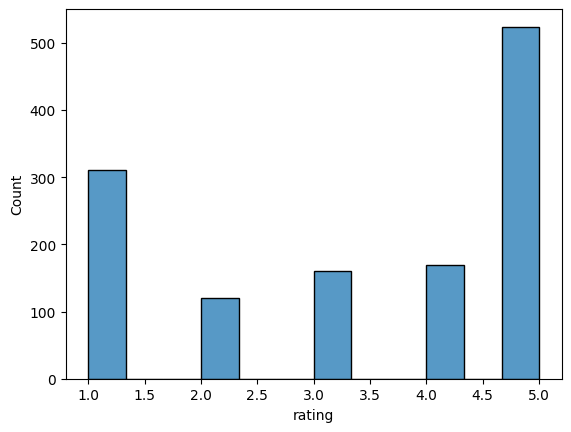

In [ ]:
sns.histplot(data=df_stat_zenmoney, x='rating')

<Axes: xlabel='rating', ylabel='Count'>

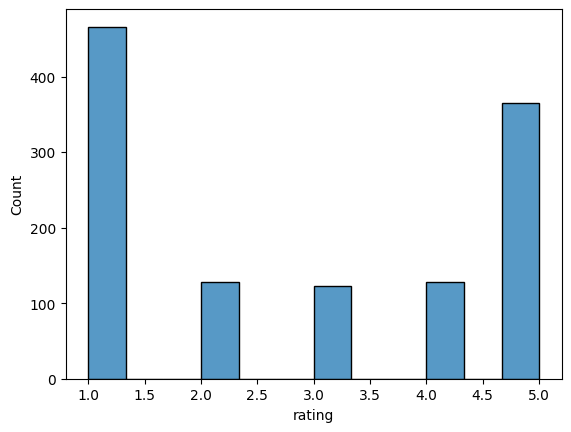

In [ ]:
sns.histplot(data=df_stat_coinkeeper, x='rating')

In [ ]:
stats.shapiro(df_stat_coinkeeper.rating)

ShapiroResult(statistic=0.7860406041145325, pvalue=4.149670747598938e-37)

In [ ]:
stats.shapiro(df_stat_zenmoney.rating)

ShapiroResult(statistic=0.7951998114585876, pvalue=2.037789750765561e-37)

Также видим точно определенное значение p-value < 0 => данные ненормально распределены

Для того, чтобы убедиться, что медианы в выборке значимо отличаются, проведем тест Манна Уитни, в котором сравним медианы двух приложений

Мы можем сравнивать два приложения, тк по количеству отзывов и времени их сбора они совпадают

In [ ]:
df_stat_zenmoney.describe()

,index,rating,date
count,1284.000000,1284.000000,1284
mean,729.503115,3.372274,2023-07-09 05:36:26.915887872
min,0.000000,1.000000,2022-10-30 00:00:00
25%,360.750000,2.000000,2023-03-01 00:00:00
50%,734.500000,4.000000,2023-07-11 00:00:00
75%,1094.250000,5.000000,2023-11-08 06:00:00
max,1465.000000,5.000000,2024-05-04 00:00:00
std,423.826779,1.639357,NaN


In [ ]:
df_stat_coinkeeper.describe()

,index,rating,date
count,1210.000000,1210.000000,1210
mean,2110.579339,2.833058,2023-05-11 23:56:25.785123840
min,1466.000000,1.000000,2022-10-05 00:00:00
25%,1783.250000,1.000000,2023-01-23 06:00:00
50%,2106.500000,3.000000,2023-04-17 00:00:00
75%,2434.750000,5.000000,2023-09-09 00:00:00
max,2769.000000,5.000000,2024-02-09 00:00:00
std,377.338559,1.712668,NaN


In [ ]:
stat = stats.mannwhitneyu(df_stat_coinkeeper.rating, df_stat_zenmoney.rating)

In [ ]:
round(stat[1], 2)

0.0

P-value получился сильно < 5%, поэтому делаем вывод, что медианы в двух приложениях статистически значимо отличаются друг от друга. Значит, при условии, что все отзывы были собраны честно, мы можем сказать, что zen money лучше, чем coin keeper

In [ ]:
df_stat_coinkeeper.sample(3)

,index,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,subcategory
1606,1816,coin_keeper,com.disrapp.coinkeeper.material,5,29 августа 2023 г.,2023-08-29,Отличное приложение. Спасибо,no topics,positive,The review is positive but does not mention an...,No Category,Suggestions for Improvement
12,1827,coin_keeper,com.disrapp.coinkeeper.material,3,22 августа 2023 г.,2023-08-22,Пользуюсь этим приложением несколько лет. В пр...,App Autonomy and Intrusiveness,negative,The main themes extracted from the review focu...,UI&UX,Access Permissions
1898,1550,coin_keeper,com.disrapp.coinkeeper.material,1,26 декабря 2023 г.,2023-12-26,Жадные вы ребята,no topics,negative,No topics related to the application's functio...,No Category,Suggestions for Improvement


In [ ]:
df_stat_zenmoney.sample(3)

,index,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,subcategory
1006,386,zen_money,ru.zenmoney.androidsub,4,31 октября 2023 г.,2023-10-31,"Удобный интерфейс, можно подстроить под себя, ...",Notification issue,negative,The main themes extracted from the review are ...,Technical Issues,Notification Issues
1236,120,zen_money,ru.zenmoney.androidsub,1,2 марта 2024 г.,2024-03-02,Уже 3 дня не работает синхронизация с Альфа ба...,Sync issue with Alpha Bank in Belarus,negative,The main topic of the review is the synchroniz...,Integration and Synchronization,Bank Synchronization
411,124,zen_money,ru.zenmoney.androidsub,1,24 февраля 2024 г.,2024-02-24,Упорно игнорируют сообщения о багах в синхрони...,Ignoring Bug Reports,negative,The main themes extracted from the review are ...,Technical Issues,Bug Reports and Fixes


In [ ]:
category = df_stat.category.unique()

In [ ]:
for category in category:
    df_ck = df_stat_coinkeeper[df_stat_coinkeeper['category'] == category]
    df_zm = df_stat_zenmoney[df_stat_zenmoney['category'] == category]
    stat = stats.mannwhitneyu(df_ck.rating, df_zm.rating)
    print(category, ' p-value: ', round(stat[1],2)*100, '%')

App Functionality  p-value:  0.0 %
Customer Support  p-value:  0.0 %
Technical Issues  p-value:  2.0 %
UI&UX  p-value:  1.0 %
Financial Tracking and Management  p-value:  69.0 %
No Category  p-value:  37.0 %
Integration and Synchronization  p-value:  78.0 %
Security and Privacy  p-value:  50.0 %
Subscription and Payments  p-value:  17.0 %


In [ ]:
df_ck_TI = df_stat_coinkeeper[df_stat_coinkeeper['category'] == 'Technical Issues']
df_zm_TI = df_stat_zenmoney[df_stat_zenmoney['category'] == 'Technical Issues']

In [ ]:
stats.mannwhitneyu(df_ck_TI.rating, df_zm_TI.rating, alternative = 'less')

MannwhitneyuResult(statistic=16119.5, pvalue=0.011102112490076222)

# word cloud

## Frameworks and functions

In [ ]:
!pip install wordcloud
!pip install nltk
!pip install pymystem3
!pip install pymorphy2

import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import pandas as pd
import string
import re
from random import randint
import pymorphy2

nltk.download('stopwords')
from nltk.corpus import stopwords

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 63.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=a227e8924f3e28cfd0e1c72ea8e733f4a5551af53cb98f1fe823086e421f669d
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_stat = pd.read_excel('/content/all_topics_cat_subcat.xlsx')

In [ ]:
russian_stopwords = set(stopwords.words("russian"))
russian_stopwords.update(['это', 'очень', 'не', 'за', 'на', 'и'])
mystem = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
# Preprocess text: Remove stopwords and punctuation
def preprocess_text(text):
    text_prep = re.sub(r'\bпремиум\b', 'премиум', text, flags=re.IGNORECASE)
    text_prep = re.sub(r'\приложение\b', '', text, flags=re.IGNORECASE)
    text_prep = text_prep.replace('приложение', '').replace('премиум версия', 'премиум').replace('премиум подписка', 'премиум') \
                        .replace('вечный', 'навсегда').replace('бессрочный', 'навсегда').replace('безлимитный', 'навсегда')  \
                        .replace('платный', 'премиум').replace('platinum', 'премиум').replace('платинум', 'премиум') \
                        .replace('купить премиум', 'премиум').replace('премиум подписка', 'премиум').replace('навсегда подписка', 'навсегда') \
                        .replace('полный', 'премиум').replace('год', 'премиум').replace('пользоваться премиум', 'премиум') \
                        .replace('пользоваться', '') \
                                .replace('удобный', '').replace('нравиться', '') \
                                .replace('удобно', '').replace('очень', '') \
                                .replace('отличный', '').replace('пока', '') \
                                .replace('спасибо', '').replace('несколько', '')
    tokens = mystem.lemmatize(text_prep.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in russian_stopwords]
    return " ".join(tokens)

In [ ]:
# Define a function to color words in shades of red
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({randint(0, 10)}, 100%, {randint(30, 60)}%)"

In [ ]:
def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({randint(100, 140)}, 100%, {randint(30, 60)}%)"

In [ ]:
df_stat_coinkeeper = df_stat[(df_stat['app_name'] == 'coin_keeper')]

In [ ]:
df_stat_coinkeeper.sample(3)

,index,app_name,app_id,rating,date_of_review,date,review_text,topic_name,sentiment,explanation,category,subcategory
1818,1851,coin_keeper,com.disrapp.coinkeeper.material,1,13 августа 2023 г.,2023-08-13,"Просто кривоногое криворукое приложение, с сам...",Subscription Handling,negative,The main themes extracted from the review are ...,Subscription and Payments,Subscription Activation and Management
1656,2448,coin_keeper,com.disrapp.coinkeeper.material,5,14 января 2023 г.,2023-01-14,"Недавно скачал приложение, пока всё устраивает...",usage experience,positive,The main theme of the review is the positive u...,UI&UX,Usability & Simplicity
2476,2514,coin_keeper,com.disrapp.coinkeeper.material,5,12 декабря 2022 г.,2022-12-12,"Шикарное приложение. Пользуюсь уже давно, купи...",synchronization across devices,positive,The main themes extracted from the review focu...,Integration and Synchronization,Website & Device Integration


In [ ]:
df_stat_coinkeeper['category'].unique()

array(['Customer Support', 'UI&UX', 'Financial Tracking and Management',
       'Technical Issues', 'No Category', 'App Functionality',
       'Subscription and Payments', 'Integration and Synchronization',
       'Security and Privacy'], dtype=object)

coinkeeper

In [ ]:
for category in df_stat_coinkeeper['category'].unique():
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    filename = f'/content/drive/MyDrive/tech_diploma/coinkeeper_wordclouds/{category}.png'
    plt.savefig(filename)
    plt.close(fig)    # close the figure window
    # fig.savefig('/content/drive/MyDrive/tech_diploma/coinkeeper_wordclouds/image{category + 1}.png')   # save the figure to file
    # plt.close(fig)    # close the figure window

In [ ]:
for category in df_stat_coinkeeper['category'].unique():
    n=0
    # Filter reviews for the current category
    category_reviews_neg = df_stat_coinkeeper[(df_stat_coinkeeper['category'] == category) &\
                                          (df_stat_coinkeeper['sentiment'] == 'negative')][['review_text']]

    category_reviews_neg_prep = [preprocess_text(review) for review in category_reviews_neg.review_text]
    category_reviews_neg_prep = " ".join(category_reviews_neg_prep)

    # Generate negative word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', \
                             color_func=red_color_func).generate(category_reviews_neg_prep)
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    filename = f'/content/drive/MyDrive/tech_diploma/coinkeeper_wordclouds/negative {category}.png'
    plt.savefig(filename)
    plt.close(fig)   # close the figure window

In [ ]:
from collections import Counter

d = {'sep_words' : [], 'count_words' : [], 'category' : []}
df = pd.DataFrame(data = d)

for category in df_stat_coinkeeper['category'].unique():
    # Filter reviews for the current category
    category_reviews_neg = df_stat_coinkeeper[(df_stat_coinkeeper['category'] == category) &\
                                          (df_stat_coinkeeper['sentiment'] == 'negative')][['review_text']]

    category_reviews_neg_prep = [preprocess_text(review) for review in category_reviews_neg.review_text]
    category_reviews_neg_prep = " ".join(category_reviews_neg_prep)

    words = category_reviews_neg_prep.split()
    sep_words = Counter(words).keys()
    count_words = Counter(words).values()

    d = {'sep_words' : sep_words, 'count_words' : count_words, 'category' : category}
    df1 = pd.DataFrame(data=d)

    df = pd.concat([df, df1], ignore_index = False)

df.sort_values(by = 'category', ascending = False)

,sep_words,count_words,category
570,попытаться,1.0,UI&UX
264,ведро,1.0,UI&UX
274,нолик,3.0,UI&UX
273,красный,7.0,UI&UX
272,убирать,3.0,UI&UX
...,...,...,...
191,покупка,2.0,App Functionality
190,сумма,10.0,App Functionality
189,монетка,4.0,App Functionality
188,появляться,2.0,App Functionality


In [ ]:
df_stat_zenmoney = df_stat[df_stat['app_name'] == 'zen_money']

In [ ]:
from collections import Counter

d = {'sep_words' : [], 'count_words' : [], 'category' : []}
df_zm = pd.DataFrame(data = d)

for category in df_stat_zenmoney['category'].unique():
    # Filter reviews for the current category
    category_reviews_neg = df_stat_zenmoney[(df_stat_zenmoney['category'] == category) &\
                                          (df_stat_zenmoney['sentiment'] == 'negative')][['review_text']]

    category_reviews_neg_prep = [preprocess_text(review) for review in category_reviews_neg.review_text]
    category_reviews_neg_prep = " ".join(category_reviews_neg_prep)

    words = category_reviews_neg_prep.split()
    sep_words = Counter(words).keys()
    count_words = Counter(words).values()

    d = {'sep_words' : sep_words, 'count_words' : count_words, 'category' : category}
    df1 = pd.DataFrame(data=d)

    df_zm = pd.concat([df_zm, df1], ignore_index = False)

df_zm.sort_values(by = 'category', ascending = False)

,sep_words,count_words,category
345,переходить,1.0,UI&UX
369,продукт,2.0,UI&UX
378,сообщение,2.0,UI&UX
377,появляться,2.0,UI&UX
376,возврат,2.0,UI&UX
...,...,...,...
602,итог,2.0,App Functionality
601,входящий,1.0,App Functionality
600,учитывать,1.0,App Functionality
599,запоминать,1.0,App Functionality


In [ ]:
df.to_csv('/content/drive/MyDrive/tech_diploma/df_wordcounts_coinkeeper.csv', index = False)

In [ ]:
df_zm.to_csv('/content/drive/MyDrive/tech_diploma/df_wordcounts_zenmoney.csv', index = False)

In [ ]:
for category in df_stat_coinkeeper['category'].unique():
    # Filter reviews for the current category
    category_reviews_neg = df_stat_coinkeeper[(df_stat_coinkeeper['category'] == category) &\
                                          (df_stat_coinkeeper['sentiment'] == 'negative')][['review_text']]

    category_reviews_neg_prep = [preprocess_text(review) for review in category_reviews_neg.review_text]
    category_reviews_neg_prep = " ".join(category_reviews_neg_prep)

    # Generate negative word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', \
                             color_func=red_color_func).generate(category_reviews_neg_prep)
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    filename = f'/content/drive/MyDrive/tech_diploma/coinkeeper_wordclouds/negative {category}.png'
    plt.savefig(filename)
    plt.close(fig)   # close the figure window

In [ ]:
for category in df_stat_coinkeeper['category'].unique():
    # Filter reviews for the current category
    category_reviews_pos = df_stat_coinkeeper[(df_stat_coinkeeper['category'] == category) &\
                                          (df_stat_coinkeeper['sentiment'] == 'positive')][['review_text']]

    category_reviews_pos_prep = [preprocess_text(review) for review in category_reviews_pos.review_text]
    category_reviews_pos_prep = " ".join(category_reviews_pos_prep)

    # Generate negative word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', \
                             color_func=green_color_func).generate(category_reviews_pos_prep)
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    filename = f'/content/drive/MyDrive/tech_diploma/coinkeeper_wordclouds/positive {category}.png'
    plt.savefig(filename)
    plt.close(fig)   # close the figure window

zenmoney

In [ ]:
df_stat_zenmoney = df_stat[(df_stat['app_name'] == 'zen_money')]

In [ ]:
for category in df_stat_zenmoney['category'].unique():
    # Filter reviews for the current category
    category_reviews_pos_zm = df_stat_zenmoney[(df_stat_zenmoney['category'] == category) &\
                                          (df_stat_zenmoney['sentiment'] == 'positive')][['review_text']]

    category_reviews_pos_zm_prep = [preprocess_text(review) for review in category_reviews_pos_zm.review_text]
    category_reviews_pos_zm_prep = " ".join(category_reviews_pos_zm_prep)

    # Generate negative word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', \
                             color_func=green_color_func).generate(category_reviews_pos_zm_prep)
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    filename = f'/content/drive/MyDrive/tech_diploma/zenmoney_wordclouds/positive {category}.png'
    plt.savefig(filename)
    plt.close(fig)

In [ ]:
for category in df_stat_zenmoney['category'].unique():
    # Filter reviews for the current category
    category_reviews_neg_zm = df_stat_zenmoney[(df_stat_zenmoney['category'] == category) &\
                                          (df_stat_zenmoney['sentiment'] == 'negative')][['review_text']]

    category_reviews_neg_zm_prep = [preprocess_text(review) for review in category_reviews_neg_zm.review_text]
    category_reviews_neg_zm_prep = " ".join(category_reviews_neg_zm_prep)

    # Generate negative word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', \
                             color_func=red_color_func).generate(category_reviews_neg_zm_prep)
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    filename = f'/content/drive/MyDrive/tech_diploma/zenmoney_wordclouds/neagtive {category}.png'
    plt.savefig(filename)
    plt.close(fig)